In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct
from pytz import timezone

import sys
sys.path.append('../../../')

from utils.plot import config_matplotlib, figsize, fig_save_and_show, plot_events_data
from utils.optimization import MyOptimizationProblem, convert_to_model_params, plot_optimization_params, plot_optimization_error, plot_compare, compute_metrics, save_model_params_to_json, load_model_params_from_json
from utils.data import get_events, get_sections, load_df, process_df, export_dataframe_to_latex
from utils.sensitivity_analysis import describe_param_with_uniform_distribution, describe_param_with_log_uniform_distribution, describe_param_with_triangular_distribution, describe_param_with_normal_distribution, describe_param_with_truncated_normal_distribution, describe_param_with_log_normal_distribution, wrapped_model_function, create_problem_spec_and_sample, plot_sampled_distribuitions, evaluate_problem, analyze_time_step, analyze_problem, sobol_sensitivity_analysis_from_model_params_to_outputs, plot_sensitivity_analysis, plot_sensitivity_analysis_heatmaps, get_region_mean, plot_sensitivity_analysis_bars

import warnings
warnings.filterwarnings("ignore")

config_matplotlib()
latex_img_path = '/home/joaoantoniocardoso/workspace_TCC/repo/thesis/assets/generated/'
latex_tex_path = '/home/joaoantoniocardoso/workspace_TCC/repo/thesis/tex/generated/'

# Obtendo os dados do fabricante

Para que seja possível realizarmos uma otimização, primeiro é necessário obter os dados das curvas de perfomrance disponibilizadas pelo fabricante.

O Motor **ME0909** é produzido pela **Motenergy**, e embora ele possua um site, disponibiliza apenas os desenhos do motor, não as curvas de performance. Felizmente os distribuidores e vendedores disponibilizam, sendo encontrado na forma vetorizada (maior qualidade) no [evdrives](http://www.evdrives.com/content/Motors/ME0909/ME0909_Performance_Data.pdf).

Para extrair os dados dessas curvas existem softwares especializados, inclusive em python, um excelente tutorial pode ser encontrado em [matthewkudija.com](https://matthewkudija.com/blog/2018/05/05/digitize-graph/) e [towardsdatascience.com](https://towardsdatascience.com/extracting-digitising-data-from-plots-in-scientific-papers-or-images-6e098cb887aa). Aqui foi utilizado o [WebPlotDigitizer](https://automeris.io/WebPlotDigitizer) e os dados foram exportados como um arquivo _.csv_ para cada curva extraída (salvos [aqui](data/datasheet/raw)), portanto, precisamos abrir todos esses dados e linearizá-los para uma mesma escala no eixo X (torque na unidade $lb\,in$). O projeto do WebPlotDigitizer foi salvo no arquivo [me0909.json](data/datasheet/project/me0909.json), que pode ser importado no WebPlotDigitizer caso necessário realizar ajustes ou re-exportar os dados.

Para trabalhar com os arquivos, podemos acessar todos os arquivos de uma pasta do sistema de arquivos usando a biblioteca _glob_:

In [2]:
import glob
raw_csv_files = sorted(glob.glob("data/datasheet/raw/*.csv"))
for raw_filename in raw_csv_files: print(raw_filename)

data/datasheet/raw/24V CCW Amps.csv
data/datasheet/raw/24V CCW Eff.csv
data/datasheet/raw/24V CCW RPM.csv
data/datasheet/raw/24V CCW Volts.csv
data/datasheet/raw/24V CCW Watts Out.csv
data/datasheet/raw/24V CW Amps.csv
data/datasheet/raw/24V CW Eff.csv
data/datasheet/raw/24V CW RPM.csv
data/datasheet/raw/24V CW Volts.csv
data/datasheet/raw/24V CW Watts Out.csv
data/datasheet/raw/36V CCW Amps.csv
data/datasheet/raw/36V CCW Eff.csv
data/datasheet/raw/36V CCW RPM.csv
data/datasheet/raw/36V CCW Volts.csv
data/datasheet/raw/36V CCW Watts Out.csv
data/datasheet/raw/36V CW Amps.csv
data/datasheet/raw/36V CW Eff.csv
data/datasheet/raw/36V CW RPM.csv
data/datasheet/raw/36V CW Volts.csv
data/datasheet/raw/36V CW Watts Out.csv
data/datasheet/raw/48V CCW Amps.csv
data/datasheet/raw/48V CCW Eff.csv
data/datasheet/raw/48V CCW RPM.csv
data/datasheet/raw/48V CCW Volts.csv
data/datasheet/raw/48V CCW Watts Out.csv
data/datasheet/raw/48V CW Amps.csv
data/datasheet/raw/48V CW Eff.csv
data/datasheet/raw/48

Para simplificar o trabalho no momento da extração, foi optado pela utilização de um único eixo Y unitário para todos os dados, então precisaremos escalonar os dados, simplesmente multiplicando pelo máximo de cada eixo, armazenado o arquivo [yscales.json](data/datasheet/project/yscales.json), que podemos abrir utilizando a biblioteca _json_, convertendo para um dicionário:

In [3]:
import json
yscales_dict = json.load(open('data/datasheet/project/yscales.json'))
print(yscales_dict)

{'48V': {'Eff': 1.0, 'Watts Out': 10000, 'Volts': 50, 'Amps': 200, 'RPM': 5000}, '36V': {'Eff': 1.0, 'Watts Out': 5000, 'Volts': 50, 'Amps': 200, 'RPM': 5000}, '24V': {'Eff': 1.0, 'Watts Out': 5000, 'Volts': 50, 'Amps': 200, 'RPM': 5000}}


Podemos usar a biblioteca _pandas_ para criar diversos _DataFrames_ (estruturas de dados análogas as páginas das planilhas _Excel_), cada um contendo uma das páginas das curvas de performance do fabricante.

Para que todos os dados estejam alinhados no mesmo ponto e sejam igualmente espaçados, usamos a biblioteca _Scipy_ para realizar uma interpolação linear nos dados.

In [4]:
import pandas as pd
import scipy as sp
from os.path import basename

dataset = {
    'CW': {'24V': {}, '36V': {}, '48V': {}},
    'CCW': {'24V': {}, '36V': {}, '48V': {}}
}
for raw_filename in raw_csv_files:
    # Get the curve information from the filename
    words = basename(raw_filename).split('.')[0].split(' ')
    voltage = words[0]
    direction = words[1]
    name = ' '.join(words[2:])

    lbin_to_nm = 0.11298482902761668

    # Read and interpolate/extrapolate to a common linear torque axis
    df = pd.read_csv(raw_filename, header=0, names=['x', 'y'])
    f = sp.interpolate.interp1d(
        df['x'], df['y'],
        kind='linear',
        fill_value="extrapolate",
        assume_sorted=False,
        copy=False
    )
    xnew = np.linspace(start=0, stop=15/lbin_to_nm, num=50)
    ynew = f(xnew)

    # Rescale torque to Nm and data to its own yscale
    xnew *= lbin_to_nm
    ynew *= yscales_dict[voltage][name]

    # Add to the dict:
    dataset[direction][voltage]['Torque'] = xnew
    dataset[direction][voltage][name] = ynew

# Rename columns
columns = { # old column name: new column name
    'Volts': 'motor_v',
    'Amps': 'motor_i',
    'Torque': 'motor_q_load',
    'Watts Out': 'motor_p_out',
    'RPM': 'motor_w',
    'Eff': 'motor_eta'
}
df_CW_24V = pd.DataFrame(dataset['CW']['24V']).rename(columns=columns)
df_CCW_24V = pd.DataFrame(dataset['CCW']['24V']).rename(columns=columns)
df_CW_36V = pd.DataFrame(dataset['CW']['36V']).rename(columns=columns)
df_CCW_36V = pd.DataFrame(dataset['CCW']['36V']).rename(columns=columns)
df_CW_48V = pd.DataFrame(dataset['CW']['48V']).rename(columns=columns)
df_CCW_48V = pd.DataFrame(dataset['CCW']['48V']).rename(columns=columns)
del dataset

dfs = [df_CCW_24V, df_CW_36V, df_CCW_36V, df_CW_48V, df_CCW_48V]

# Compute input power
df_CW_24V['motor_p_in'] = df_CW_24V['motor_v'] * df_CW_24V['motor_i']
df_CCW_24V['motor_p_in'] = df_CCW_24V['motor_v'] * df_CCW_24V['motor_i']
df_CW_36V['motor_p_in'] = df_CW_36V['motor_v'] * df_CW_36V['motor_i']
df_CCW_36V['motor_p_in'] = df_CCW_36V['motor_v'] * df_CCW_36V['motor_i']
df_CW_48V['motor_p_in'] = df_CW_48V['motor_v'] * df_CW_48V['motor_i']
df_CCW_48V['motor_p_in'] = df_CCW_48V['motor_v'] * df_CCW_48V['motor_i']

display(df_CW_36V)

motor_q_load     motor_i  motor_eta      motor_w    motor_v  motor_p_out  \
0       0.000000    7.378116  -1.624595  3326.988756  35.837780   -32.209044   
1       0.306122    8.660227   0.119502  3326.988756  35.848708    77.791037   
2       0.612245    9.942337   0.532240  3326.988756  35.859636   187.791119   
3       0.918367   11.475444   0.710054  3321.413597  35.861901   290.365112   
4       1.224490   13.131947   0.834336  3313.101785  35.859465   401.060758   
5       1.530612   15.344635   0.881210  3285.241083  35.860179   515.256747   
6       1.836735   17.979693   0.900506  3278.011333  35.861040   619.083149   
7       2.142857   21.449769   0.906081  3272.802869  35.861967   724.723532   
8       2.448980   24.917298   0.911266  3266.192819  35.862870   823.245605   
9       2.755102   27.611590   0.916000  3258.227656  35.863838   926.107733   
10      3.061224   30.115396   0.932571  3239.847360  35.864321  1027.185170   
11      3.367347   33.644359   0.913530  3233.964426  35.865952  1123.152592   
12      3.673469   36.374555   0.923731  3224.000491  35.862492  1223.673553   
13      3.979592   39.745063   0.919247  3219.005022  35.861576  1326.734467   
14      4.285714   42.466311   0.918646  3207.828277  35.860662  1428.276372   
15      4.591837   45.577345   0.919929  3209.910826  35.860408  1533.080246   
16      4.897959   49.126691   0.913258  3193.060004  35.858832  1621.431123   
17      5.204082   51.841237   0.915207  3177.852168  35.859066  1726.991146   
18      5.510204   54.764049   0.917246  3161.228694  35.863463  1815.831641   
19      5.816327   57.798509   0.916668  3161.605569  35.860914  1917.109318   
20      6.122449   60.751004   0.917180  3151.027358  35.859988  2017.155491   
21      6.428571   64.155083   0.913594  3150.491207  35.859116  2114.377050   
22      6.734694   66.934393   0.913452  3136.127076  35.859804  2208.191296   
23      7.040816   70.425627   0.906436  3130.041628  35.859739  2306.841779   
24      7.346939   72.817017   0.910339  3111.269530  35.860708  2400.714239   
25      7.653061   76.456602   0.905557  3105.462724  35.861569  2486.102397   
26      7.959184   78.498232   0.914504  3100.930710  35.865008  2585.555776   
27      8.265306   81.767462   0.902703  3088.677265  35.863399  2679.293035   
28      8.571429   85.041805   0.904425  3084.304626  35.864367  2768.454174   
29      8.877551   88.120822   0.898456  3071.847336  35.863793  2854.398422   
30      9.183673   91.551398   0.891251  3055.316902  35.863074  2937.490772   
31      9.489796   94.156125   0.896960  3048.974784  35.861963  3043.709641   
32      9.795918   96.328957   0.896542  3045.295583  35.861056  3121.696856   
33     10.102041  100.168139   0.891643  3037.519771  35.861983  3213.389894   
34     10.408163  103.353591   0.889652  3032.824295  35.863989  3301.005531   
35     10.714286  106.280006   0.884348  3022.340040  35.863119  3393.196889   
36     11.020408  109.479076   0.881117  2993.253991  35.862192  3476.622493   
37     11.326531  112.645679   0.881117  2990.995450  35.863992  3561.846872   
38     11.632653  116.353425   0.871883  2988.429415  35.860394  3639.136597   
39     11.938776  118.608970   0.874445  2985.858444  35.859459  3735.715257   
40     12.244898  121.701834   0.870801  2982.765732  35.858638  3812.416273   
41     12.551020  124.316942   0.871392  2981.770529  35.859953  3897.851249   
42     12.857143  127.349478   0.868989  2945.406769  35.860268  3993.475042   
43     13.163265  129.619697   0.871127  2944.834122  35.861236  4076.281944   
44     13.469388  132.506911   0.869533  2938.732547  35.862466  4151.126609   
45     13.775510  135.030410   0.869734  2935.141186  35.863066  4238.841509   
46     14.081633  139.039777   0.862807  2926.601402  35.862740  4321.524317   
47     14.387755  144.004602   0.843999  2891.828559  35.843130  4385.525587   
48     14.693878  147.210452   0.839220  2882.209315  35.929468  4455.244501   
49  

In [5]:
df_CW_24V['Direction'] = 'CW'
df_CCW_24V['Direction'] = 'CCW'
df_CW_36V['Direction'] = 'CW'
df_CCW_36V['Direction'] = 'CCW'
df_CW_48V['Direction'] = 'CW'
df_CCW_48V['Direction'] = 'CCW'

df_CW_24V['Test'] = '24V'
df_CCW_24V['Test'] = '24V'
df_CW_36V['Test'] = '36V'
df_CCW_36V['Test'] = '36V'
df_CW_48V['Test'] = '48V'
df_CCW_48V['Test'] = '48V'

# df = pd.concat([df_CCW_24V, df_CCW_36V, df_CCW_48V])
df = pd.concat([df_CW_24V, df_CW_36V, df_CW_48V])

df['motor_w'] *= 2 * np.pi / 60

df = df.set_index(['Direction', 'Test'])
display(df)

df = df.clip(lower=0)

motor_q_load     motor_i  motor_eta     motor_w    motor_v  \
Direction Test                                                               
CW        24V       0.000000    6.443637   0.023128  231.401595  23.979559   
          24V       0.306122    8.298535   0.327033  230.430195  23.974406   
          24V       0.612245   10.153433   0.532296  229.458796  23.969252   
          24V       0.918367   11.618421   0.741711  228.548605  23.969893   
          24V       1.224490   13.794902   0.810775  227.599914  23.950926   
...                      ...         ...        ...         ...        ...   
          48V      13.775510  137.762281   0.847917  408.988873  47.962743   
          48V      14.081633  141.950174   0.836532  405.986452  47.962638   
          48V      14.387755  144.931979   0.837362  404.983645  47.962638   
          48V      14.693878  147.420247   0.837472  404.801242  47.955180   
          48V      15.000000  150.275740   0.835661  403.398259  47.972175   

                motor_p_out   motor_p_in  
Direction Test                            
CW        24V    -44.926370   154.515568  
          24V     39.688531   198.952439  
          24V    124.303432   243.370192  
          24V    205.135521   278.492302  
          24V    264.867699   330.400678  
...                     ...          ...  
          48V   5639.034372  6607.456858  
          48V   5732.938082  6808.304862  
          48V   5841.932778  6951.320071  
          48V   5955.681341  7069.564501  
          48V   6058.759692  7209.054047  

[150 rows x 7 columns]

Podemos refatorar o código para plotagem da curva de performance, transformando-a numa função que recebe um _dataframe_ como argumento e plotar todas as curvas de performance em sequência.

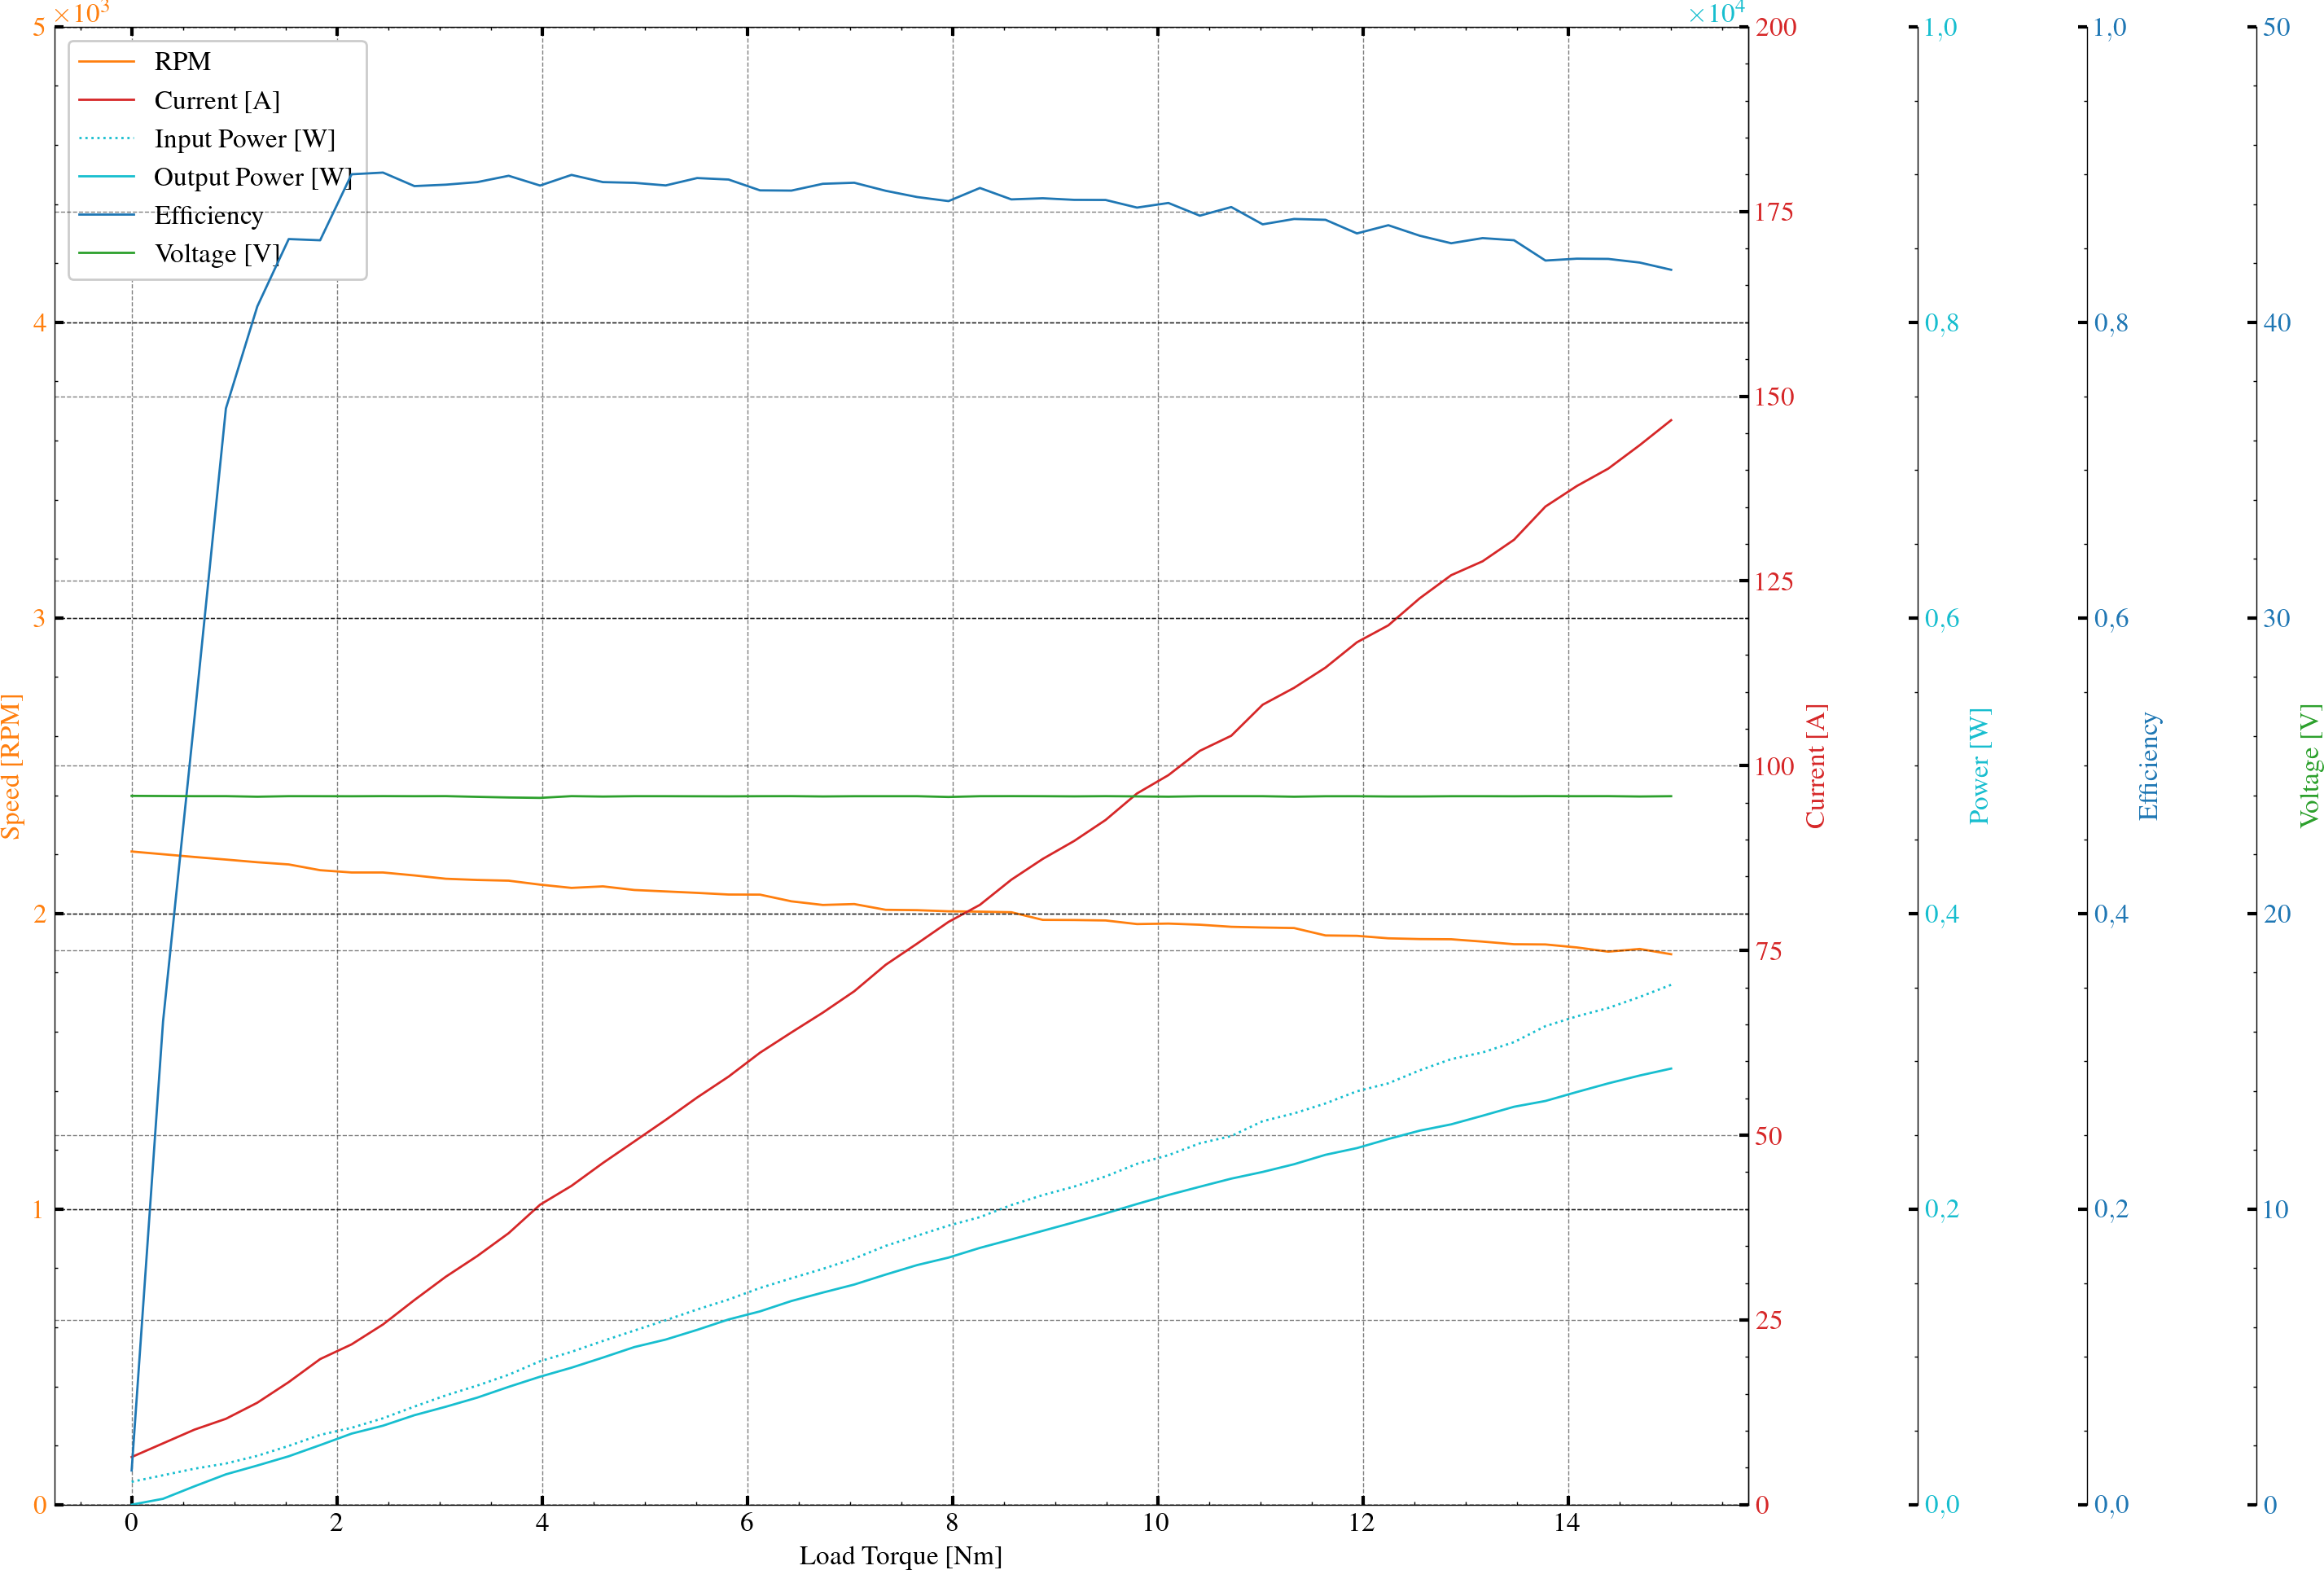

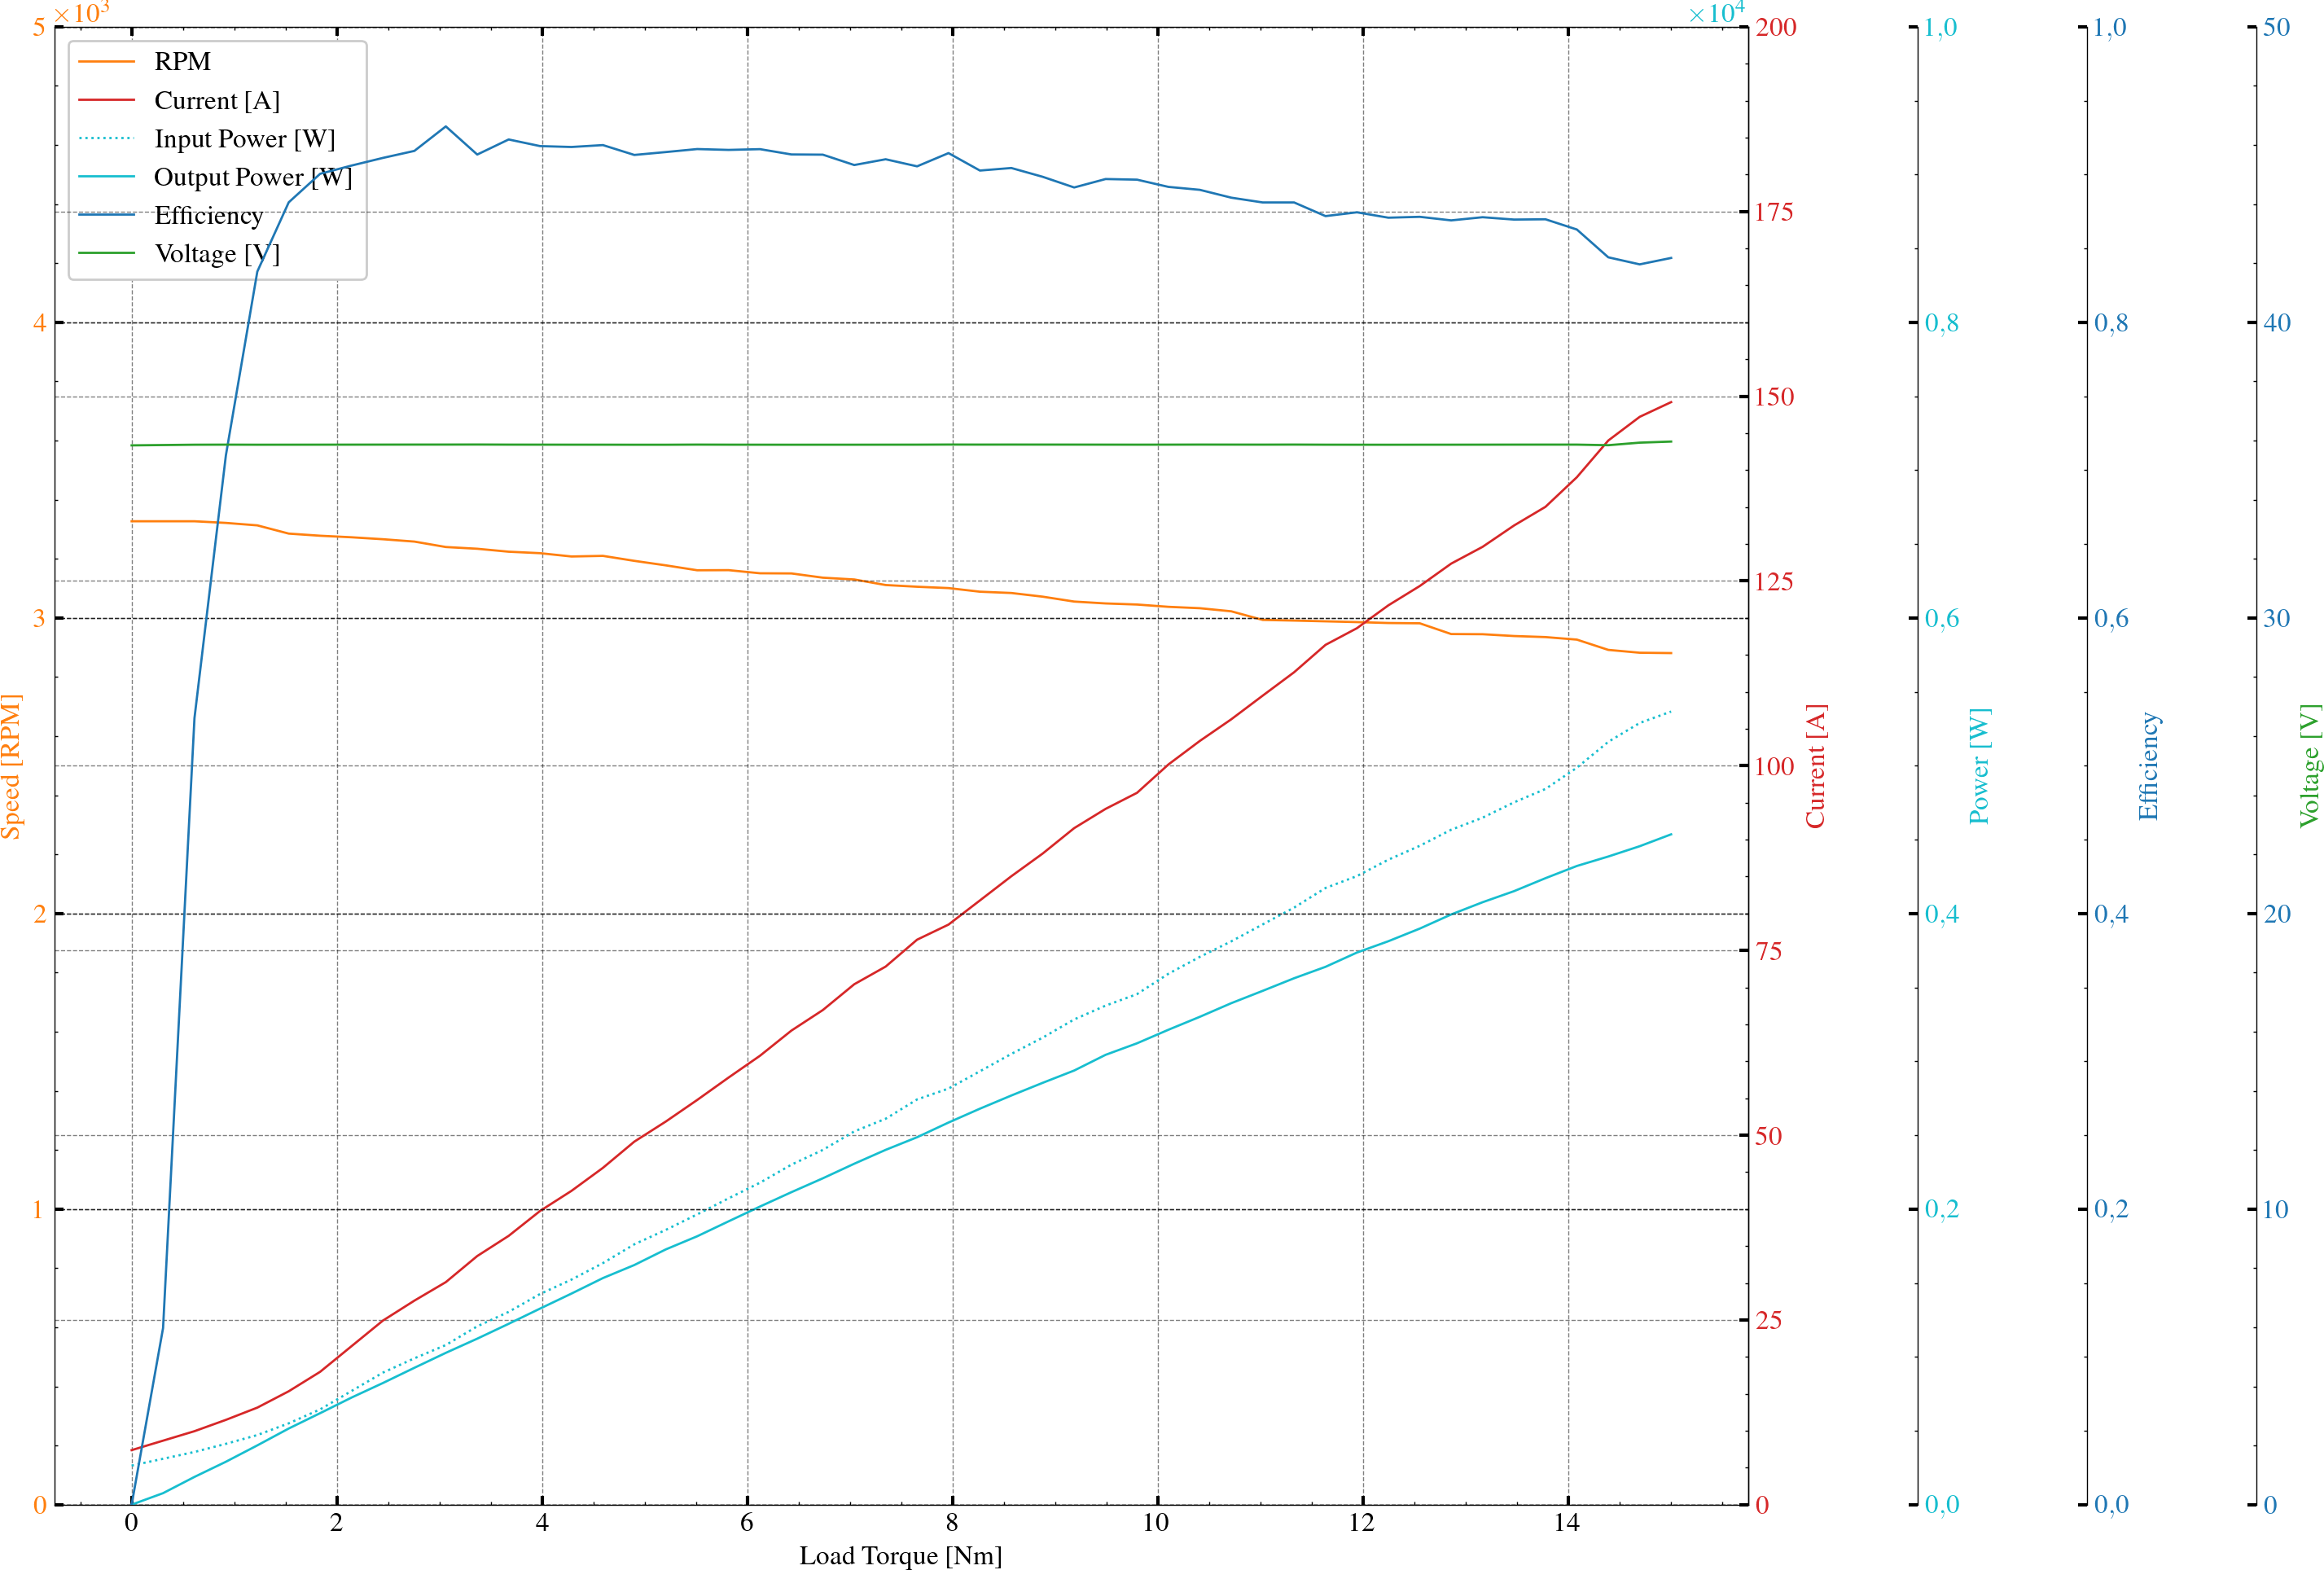

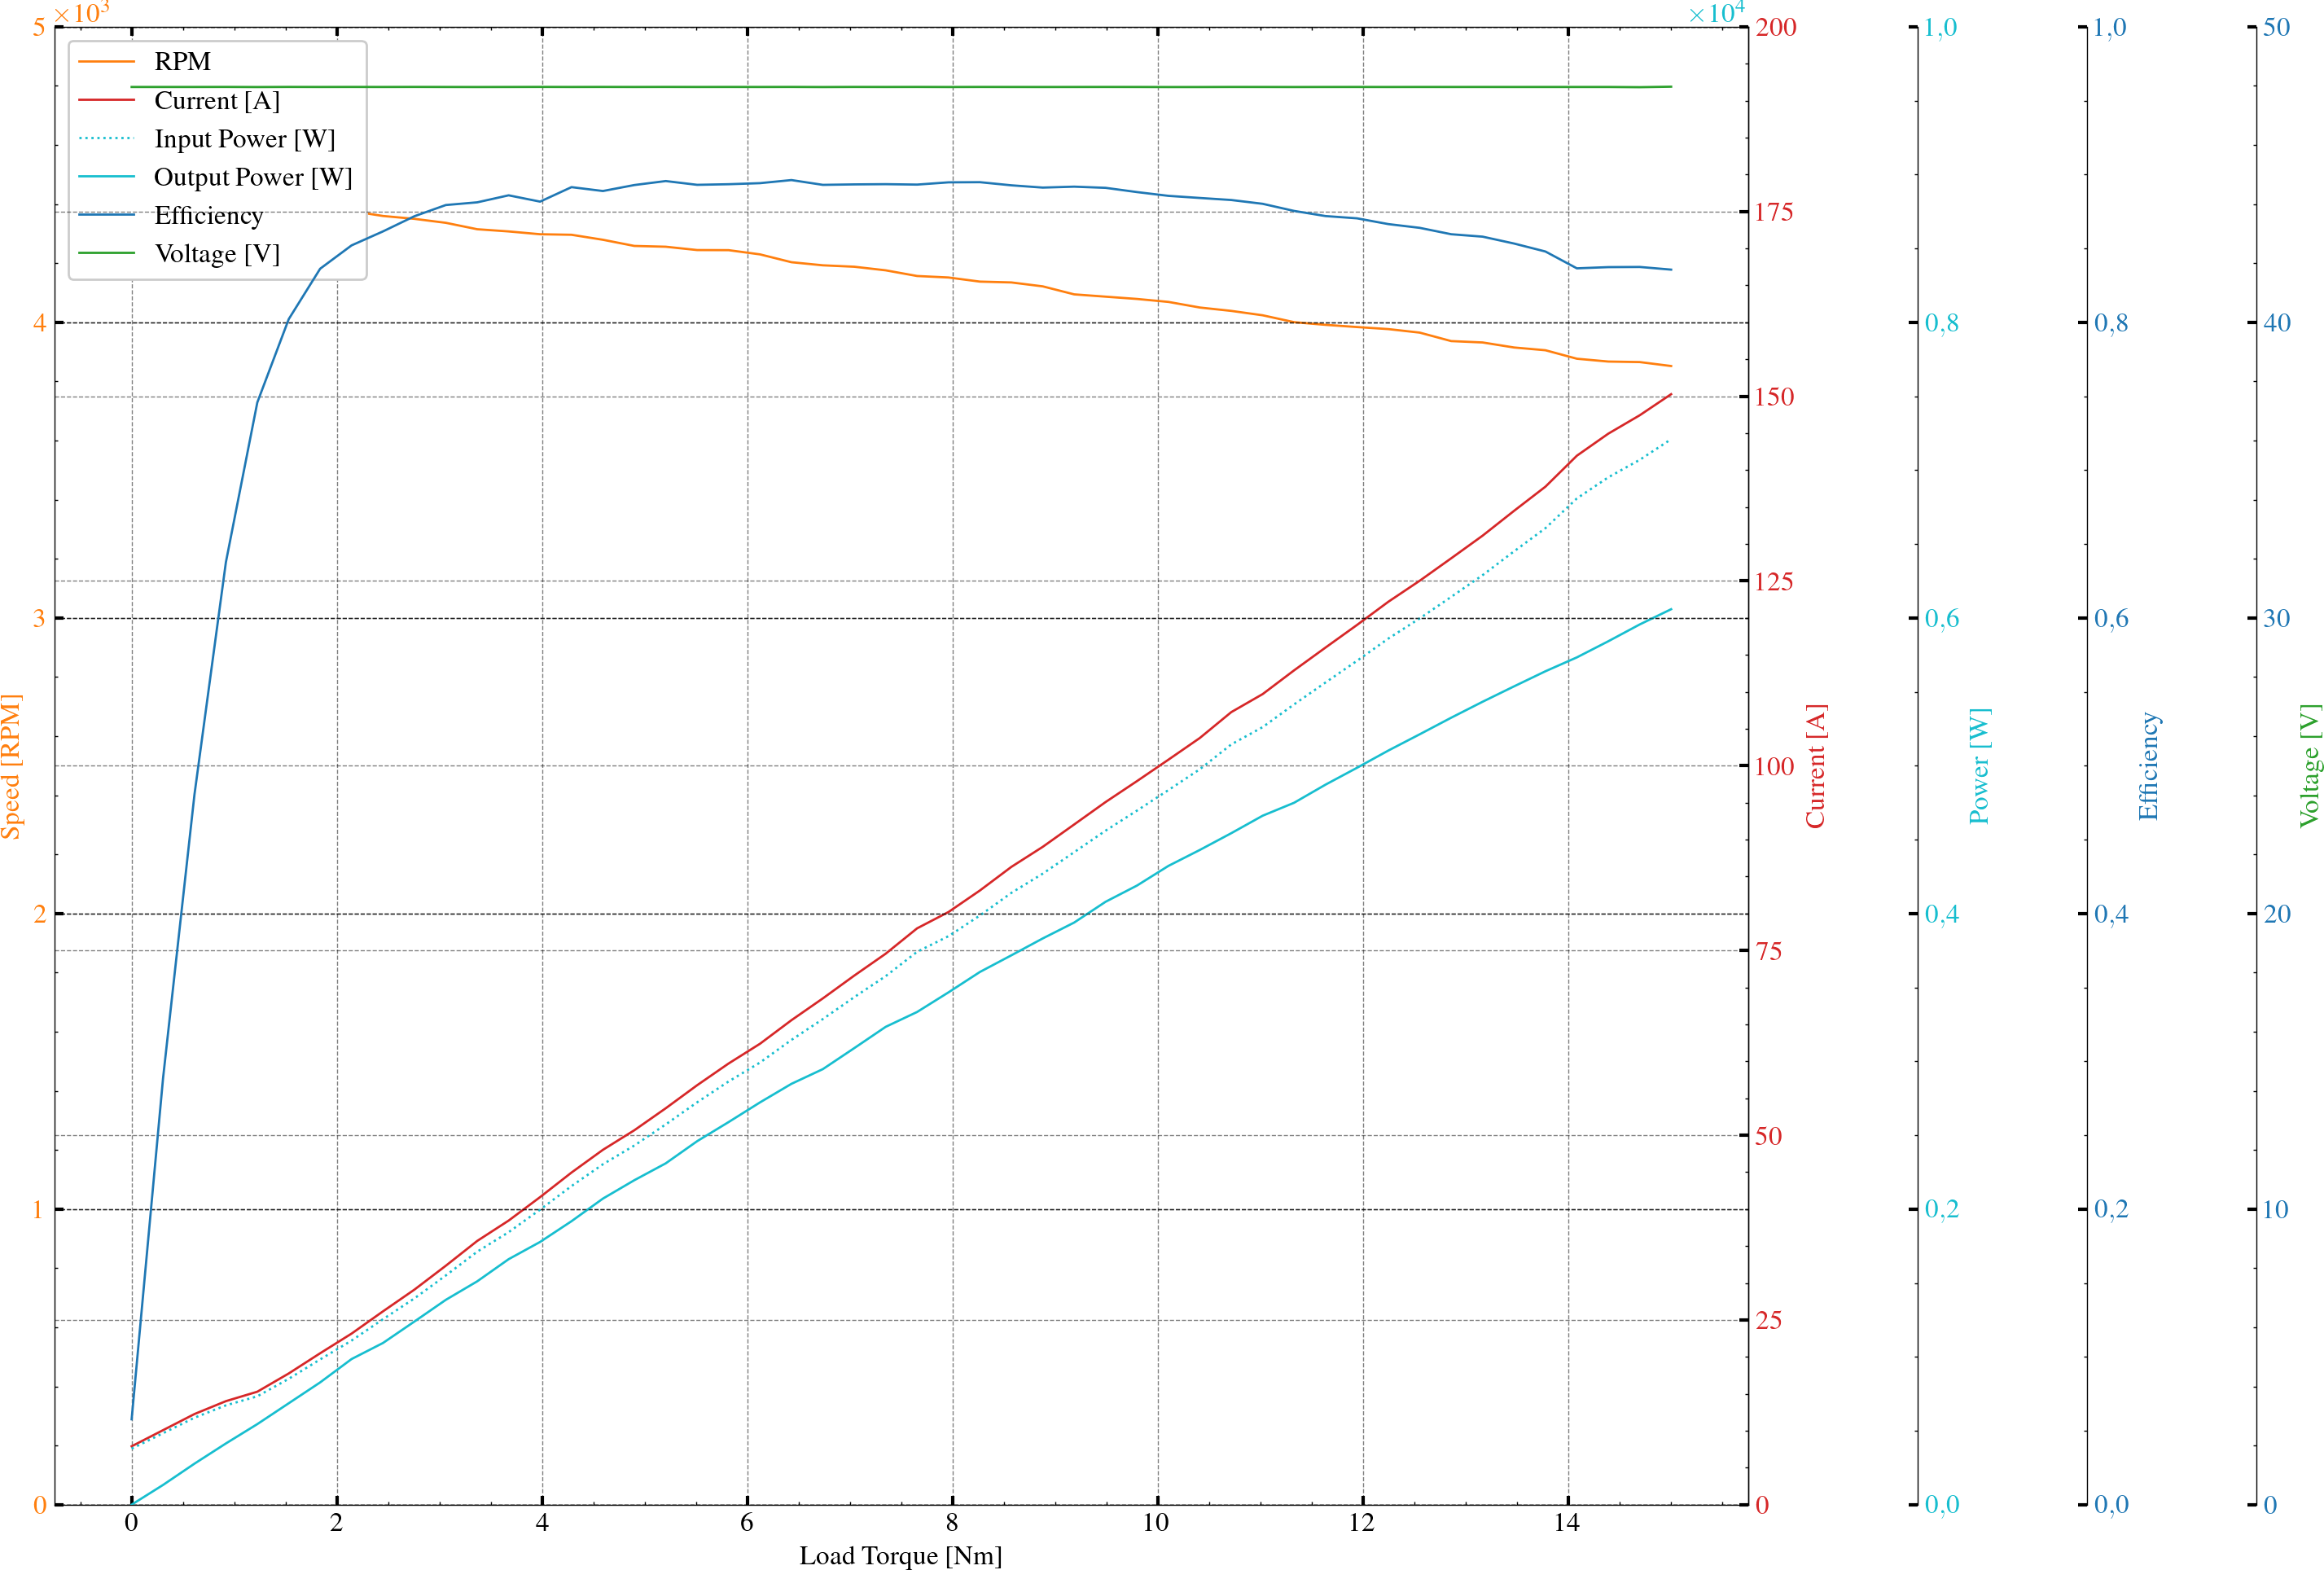

In [6]:
import matplotlib.pyplot as plt

def plot_performance_graph(df: pd.DataFrame, show=True):
    """
    Plot performance graph for motors
    The dataframe should have the following columns:
        - motor_q in nM
        - motor_i in Amps
        - motor_v in Volts
        - RPM in RPM
        - motor_p_in in Watts
        - motor_p_out in Watts
        - motor_eta from 0 to 1
    """

    def make_patch_spines_invisible(ax):
        ax.set_frame_on(True)
        ax.patch.set_visible(False)
        for sp in ax.spines.values():
            sp.set_visible(False)


    fig, ax1 = plt.subplots(figsize=(15,10))
    fig.subplots_adjust(right=0.75)

    ax2 = ax1.twinx()
    ax3 = ax1.twinx()
    ax4 = ax1.twinx()
    ax5 = ax1.twinx()

    # Offset the right spine of par2.  The ticks and label have already been
    # placed on the right by twinx above.
    ax2.spines["right"].set_position(("axes", 1.00))
    ax3.spines["right"].set_position(("axes", 1.1))
    ax4.spines["right"].set_position(("axes", 1.2))
    ax5.spines["right"].set_position(("axes", 1.3))
    # Having been created by twinx, par2 has its frame off, so the line of its
    # detached spine is invisible.  First, activate the frame but make the patch
    # and spines invisible.
    make_patch_spines_invisible(ax2)
    make_patch_spines_invisible(ax3)
    make_patch_spines_invisible(ax4)
    make_patch_spines_invisible(ax5)
    # Second, show the right spine.
    ax2.spines["right"].set_visible(True)
    ax3.spines["right"].set_visible(True)
    ax4.spines["right"].set_visible(True)
    ax5.spines["right"].set_visible(True)

    p1, = ax1.plot(df['motor_q_load'], df['motor_w'] * (60/(2*np.pi)), color="tab:orange", linestyle='solid', label='RPM', alpha=1)
    p2, = ax2.plot(df['motor_q_load'], df['motor_i'], color="tab:red", linestyle='solid', label='Current [A]', alpha=1)
    p3, = ax3.plot(df['motor_q_load'], df['motor_p_in'], color="tab:cyan", linestyle='dotted', label='Input Power [W]', alpha=1)
    p3b, = ax3.plot(df['motor_q_load'], df['motor_p_out'], color="tab:cyan", linestyle='solid', label='Output Power [W]', alpha=1)
    p4, = ax4.plot(df['motor_q_load'], df['motor_eta'], color="tab:blue", linestyle='solid', label='Efficiency', alpha=1)
    p5, = ax5.plot(df['motor_q_load'], df['motor_v'], color="tab:green", linestyle='solid', label='Voltage [V]', alpha=1)
    # tab:olive, tab:gray, tab:purple, tab:brown

#     ax1.set_xlim(...)
    ax1.set_ylim([0, 5000])
    ax2.set_ylim([0, 200])
    ax3.set_ylim([0, 10000])
    ax4.set_ylim([0, 1])
    ax5.set_ylim([0, 50])

    ax1.set_xlabel('Load Torque [Nm]')
    ax1.set_ylabel('Speed [RPM]')
    ax2.set_ylabel('Current [A]')
    ax3.set_ylabel('Power [W]')
    ax4.set_ylabel('Efficiency')
    ax5.set_ylabel('Voltage [V]')

    ax1.yaxis.label.set_color(p1.get_color())
    ax2.yaxis.label.set_color(p2.get_color())
    ax3.yaxis.label.set_color(p3.get_color())
    ax4.yaxis.label.set_color(p4.get_color())
    ax5.yaxis.label.set_color(p5.get_color())

    tkw = dict(size=4, width=1.5)

    ax1.tick_params(axis='y', labelcolor=p1.get_color(), **tkw)
    ax2.tick_params(axis='y', labelcolor=p2.get_color(), **tkw)
    ax3.tick_params(axis='y', labelcolor=p3.get_color(), **tkw)
    ax4.tick_params(axis='y', labelcolor=p4.get_color(), **tkw)
    ax5.tick_params(axis='y', labelcolor=p4.get_color(), **tkw)
    ax1.tick_params(axis='x', **tkw)

    lines = [p1, p2, p3, p3b, p4, p5]
    ax1.legend(lines, [l.get_label() for l in lines], loc=2)

    plt.tight_layout()
    plt.grid()
    if show:
        plt.show()
    
    return fig

for (direction,test) in df.index.unique():
    plot_performance_graph(df.loc[[(direction, test)]])


Com estes dados podemos, por exemplo, plotar a eficiência do motor em diferentes condições:

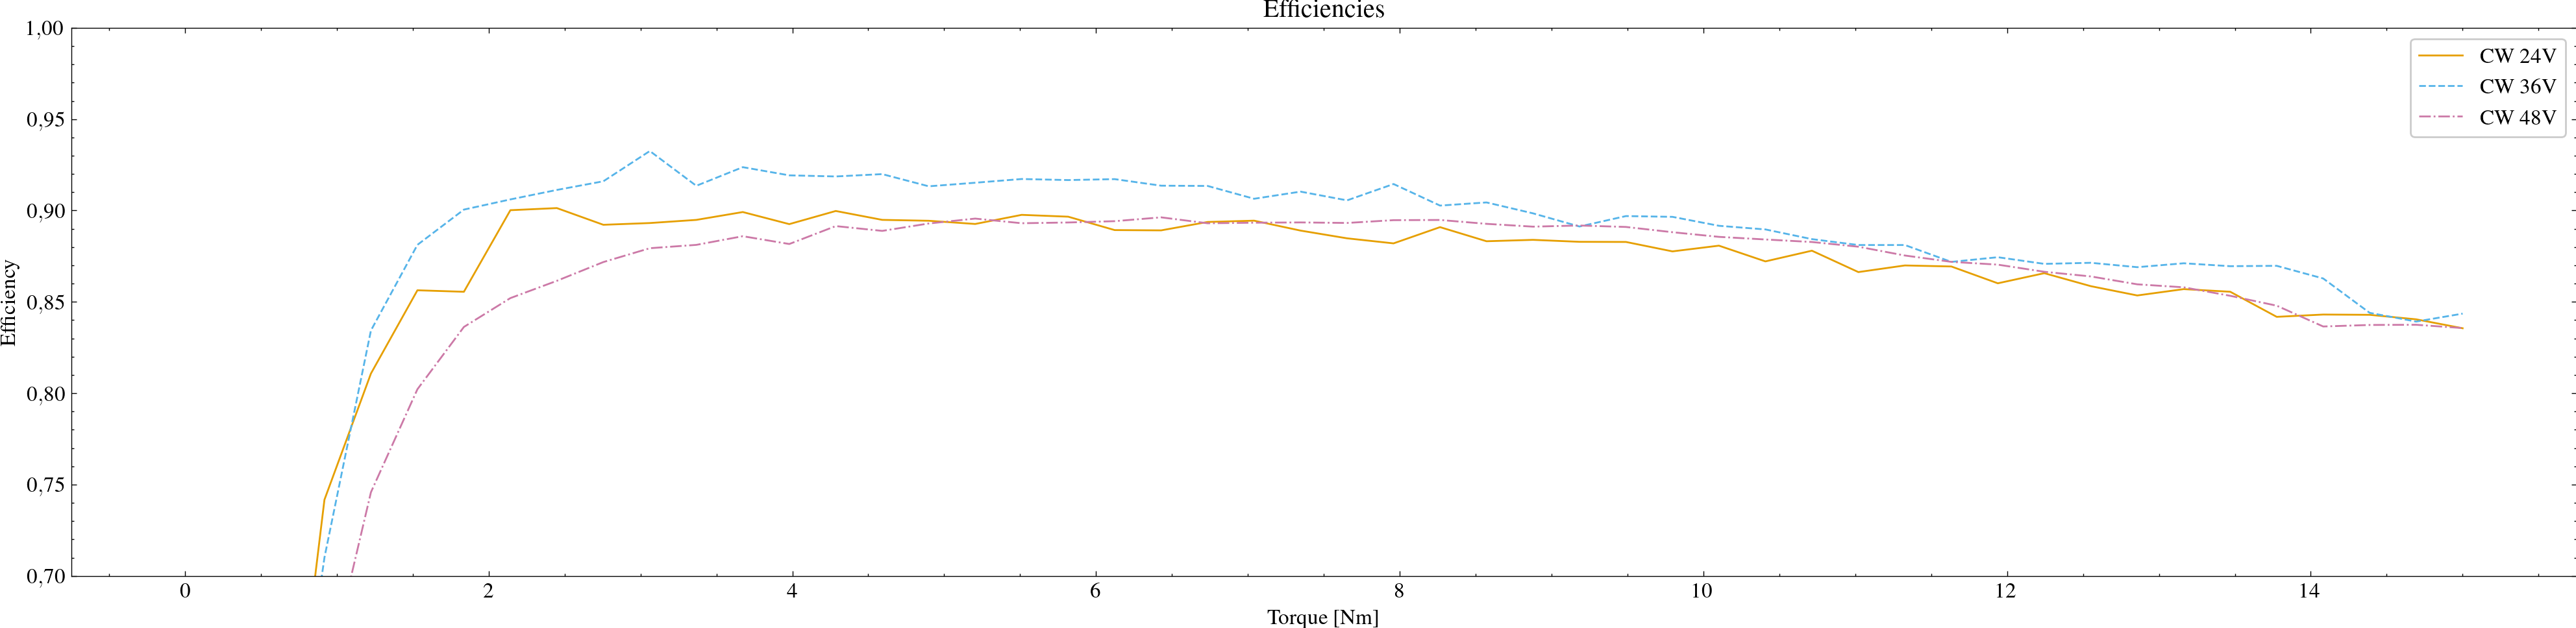

In [7]:
plt.figure(figsize=(20,5))
plt.title('Efficiencies')

for (direction,test) in df.index.unique():
    df_ = df.loc[[(direction, test)]]
    plt.plot(df_['motor_q_load'], df_['motor_eta'], label=f'{direction} {test}')

plt.legend()
plt.ylim([0.7, 1])
plt.grid()
plt.tight_layout()
plt.xlabel('Torque [Nm]')
plt.ylabel('Efficiency')
plt.show()

# Stead-State Motor Model

In [8]:
from model import SteadyStateMotor as Motor

Motor.build({})

<NonlinearIOSystem motor: ['motor_v', 'motor_q_load'] -> ['motor_i', 'motor_w']>

In [9]:
motor_params = {
    'motor_R_A': 0.1,
    'motor_B': 0.1,
    'motor_K_Q': 0.1,
    'motor_K_V': 0.1,
}

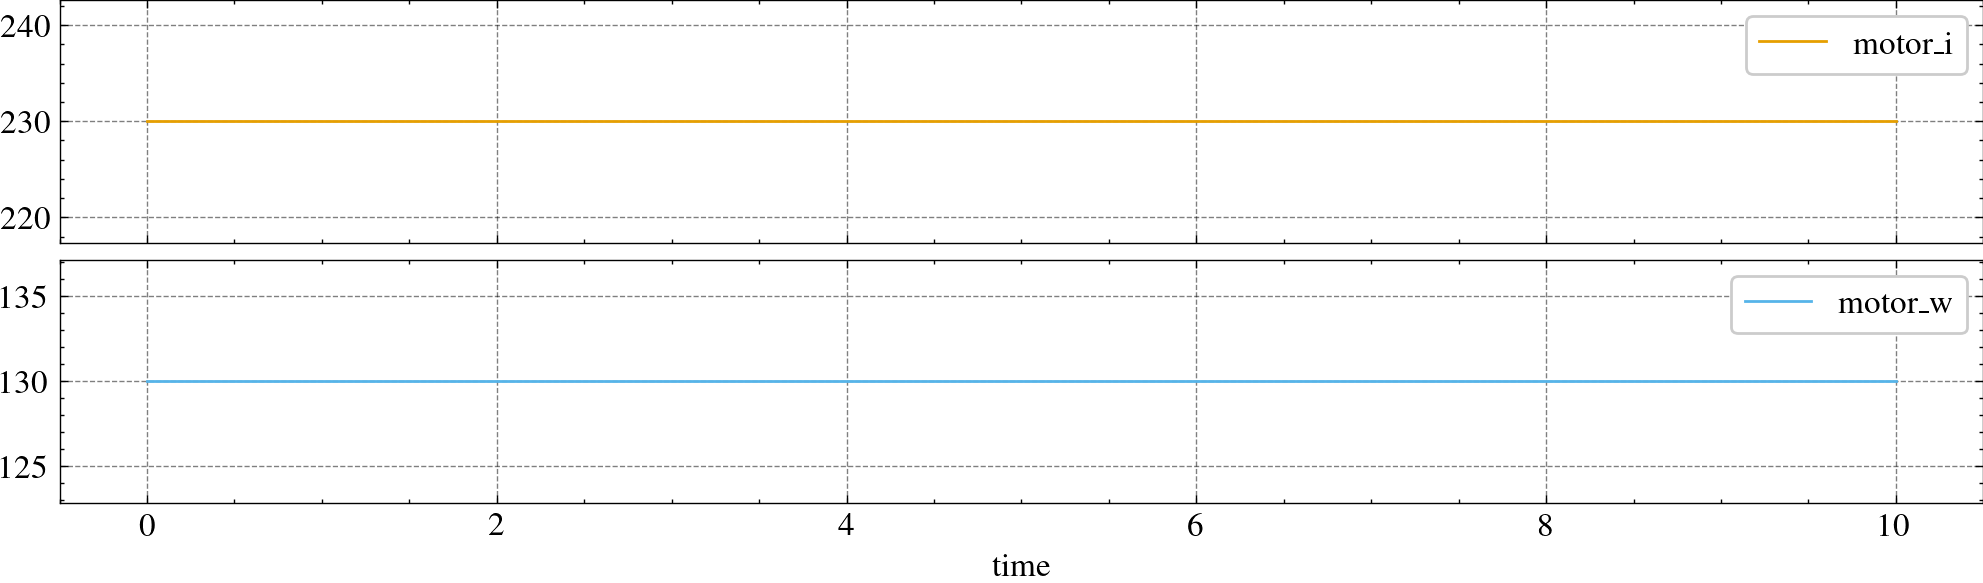

In [10]:
# Time array
T = np.linspace(0, 10, 11)

# Inputs
model_tmp = Motor.build({})
motor_v = 36
motor_q = 10
U = np.empty([model_tmp.ninputs, len(T)]) * np.nan # nan to force us to define every input
U[model_tmp.input_labels.index('motor_v')] = motor_v
U[model_tmp.input_labels.index('motor_q_load')] = motor_q

# Model
motor = Motor.build(motor_params)

# Initial state
X0 = np.zeros(motor.nstates)
# X0[motor.state_index['']] = 1

# Simulation
res = ct.input_output_response(motor, T=T, U=U, X0=X0, solve_ivp_method='Radau')
Y = res.to_pandas().set_index('time')[res.output_labels]

Y.plot(subplots=True, figsize=(10,3))
plt.show()

# Otimização

In [11]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from pymoo.optimize import minimize
from pymoo.algorithms.soo.nonconvex.nelder import NelderMead
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.algorithms.soo.nonconvex.isres import ISRES
from pymoo.algorithms.soo.nonconvex.es import ES
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
from pymoo.algorithms.soo.nonconvex.pattern import PatternSearch
from pymoo.operators.sampling.lhs import LHS
from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.parallelization.starmap import StarmapParallelization
from multiprocessing.pool import ThreadPool
from multiprocessing import Pool

def model_function(T, U, X0, **params):
    Y = ct.input_output_response(
        Motor.build(params=params),
        T=T,
        U=U,
        X0=X0,
        solve_ivp_method='Radau',
    ).to_pandas()

    motor_v = U[0]
    motor_q = U[1]
    motor_i = Y['motor_i']
    motor_w = Y['motor_w']

    motor_p_in = motor_v * motor_i
    motor_p_out = motor_w * motor_q

    motor_eta = motor_p_out / motor_p_in
    motor_eta = np.where(np.isfinite(motor_eta), motor_eta, 0)
    motor_eta = np.clip(motor_eta, 0, 1)

    Y['motor_p_in'] = motor_p_in
    Y['motor_p_out'] = motor_p_out
    Y['motor_eta'] = motor_eta

    return Y

In [12]:
# Organize the data for the fit:
#  - Since there's no dynamics involved, we can make up that each measurement were made at each 60 seconds
time = np.linspace(0, len(df)*60, len(df), dtype='timedelta64[s]')
df['time'] = time
df = df.reset_index(drop=True).set_index('time')
df['t'] = time.astype(np.float64)*1e-9  # Simulation time in seconds as floats
df

motor_q_load     motor_i  motor_eta     motor_w    motor_v  \
time                                                                          
0 days 00:00:00      0.000000    6.443637   0.023128  231.401595  23.979559   
0 days 00:01:00      0.306122    8.298535   0.327033  230.430195  23.974406   
0 days 00:02:00      0.612245   10.153433   0.532296  229.458796  23.969252   
0 days 00:03:01      0.918367   11.618421   0.741711  228.548605  23.969893   
0 days 00:04:01      1.224490   13.794902   0.810775  227.599914  23.950926   
...                       ...         ...        ...         ...        ...   
0 days 02:25:58     13.775510  137.762281   0.847917  408.988873  47.962743   
0 days 02:26:58     14.081633  141.950174   0.836532  405.986452  47.962638   
0 days 02:27:59     14.387755  144.931979   0.837362  404.983645  47.962638   
0 days 02:28:59     14.693878  147.420247   0.837472  404.801242  47.955180   
0 days 02:30:00     15.000000  150.275740   0.835661  403.398259  47.972175   

                 motor_p_out   motor_p_in             t  
time                                                     
0 days 00:00:00     0.000000   154.515568  0.000000e+00  
0 days 00:01:00    39.688531   198.952439  6.000000e-08  
0 days 00:02:00   124.303432   243.370192  1.200000e-07  
0 days 00:03:01   205.135521   278.492302  1.810000e-07  
0 days 00:04:01   264.867699   330.400678  2.410000e-07  
...                      ...          ...           ...  
0 days 02:25:58  5639.034372  6607.456858  8.758000e-06  
0 days 02:26:58  5732.938082  6808.304862  8.818000e-06  
0 days 02:27:59  5841.932778  6951.320071  8.879000e-06  
0 days 02:28:59  5955.681341  7069.564501  8.939000e-06  
0 days 02:30:00  6058.759692  7209.054047  9.000000e-06  

[150 rows x 8 columns]

In [13]:
print(Motor.build({}).input_labels)
print(Motor.build({}).output_labels)
print(df.columns)

['motor_v', 'motor_q_load']
['motor_i', 'motor_w']
Index(['motor_q_load', 'motor_i', 'motor_eta', 'motor_w', 'motor_v',
       'motor_p_out', 'motor_p_in', 't'],
      dtype='object')


n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      400 |  0.8524596973 |  0.0711118185
     2 |      800 |  0.3997171856 |  0.0393589570
     3 |     1200 |  0.3463846887 |  0.0393589570
     4 |     1600 |  0.3014194063 |  0.0393589570
     5 |     2000 |  0.2593538115 |  0.0393589570
     6 |     2400 |  0.2201375438 |  0.0393589570
     7 |     2800 |  0.1851161230 |  0.0393589570
     8 |     3200 |  0.1529010394 |  0.0393589570
     9 |     3600 |  0.1232799955 |  0.0393589570
    10 |     4000 |  0.1036338478 |  0.0393589570
    11 |     4400 |  0.0880102747 |  0.0382623605
    12 |     4800 |  0.0779255805 |  0.0382623605
    13 |     5200 |  0.0703717510 |  0.0293895894
    14 |     5600 |  0.0627754990 |  0.0293895894
    15 |     6000 |  0.0584799133 |  0.0293895894
    16 |     6400 |  0.0548259128 |  0.0244107127
    17 |     6800 |  0.0512622838 |  0.0227798729
    18 |     7200 |  0.0484982967 |  0.0055004845
    19 |     7600 |  0.0462977546 |  0.0055004845


{'motor_R_A': nan, 'motor_B': nan, 'motor_K_Q': nan, 'motor_K_V': nan}

Best parameters found:


{'motor_R_A': 0.03211280350781205,
 'motor_B': 0.0012793008044770459,
 'motor_K_Q': 0.10543193741528227,
 'motor_K_V': 0.10337093946599393}

Objective value at solution: [0.00055229]


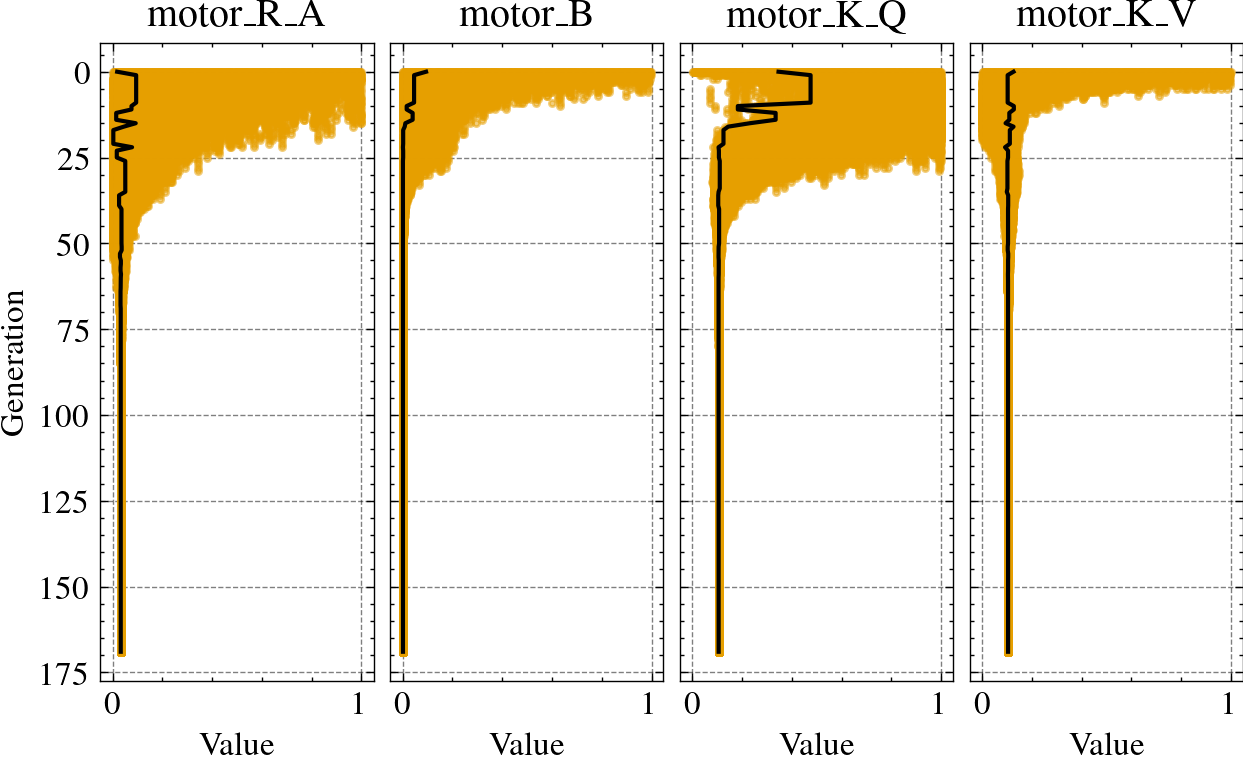

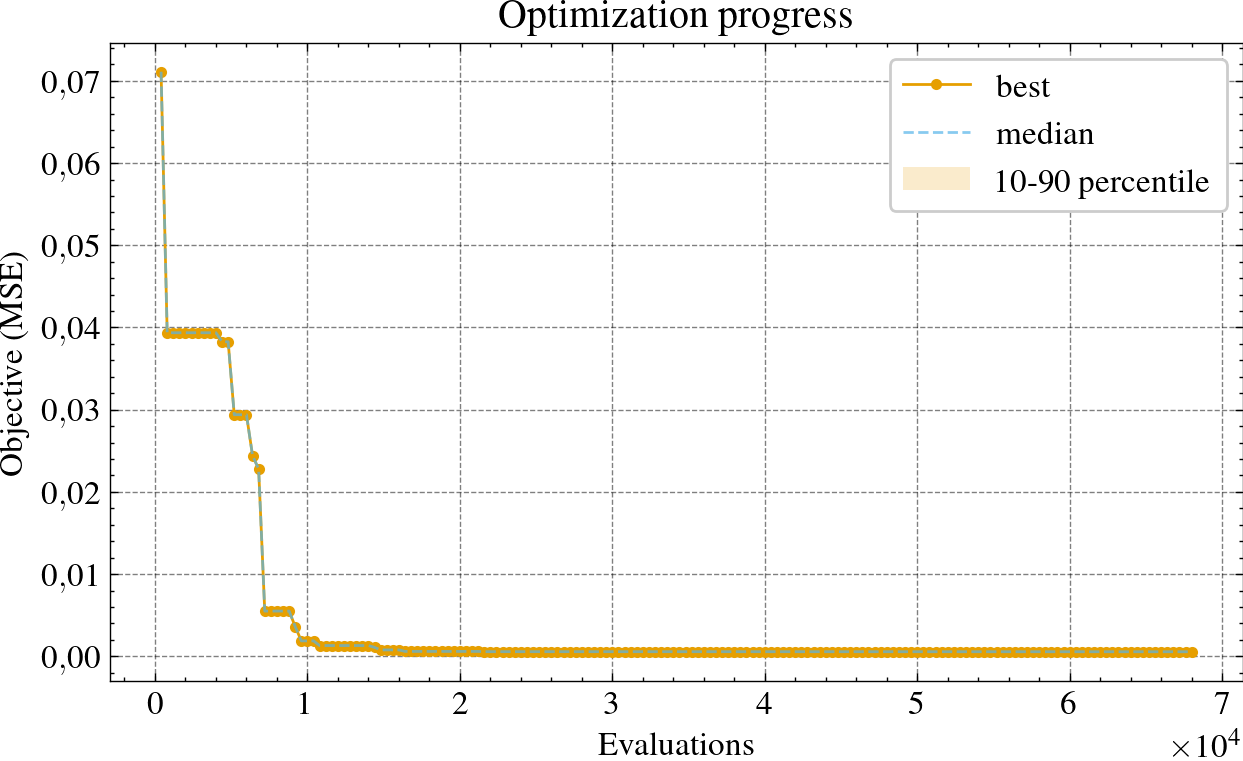

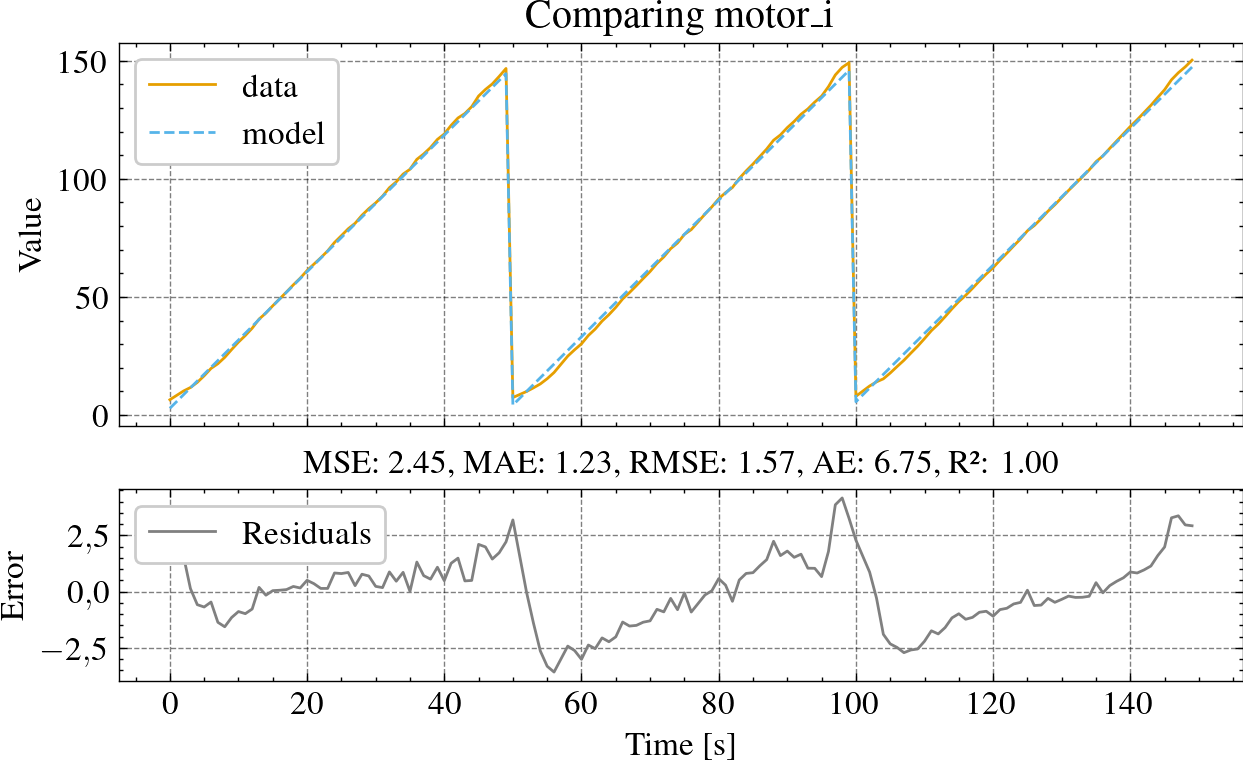

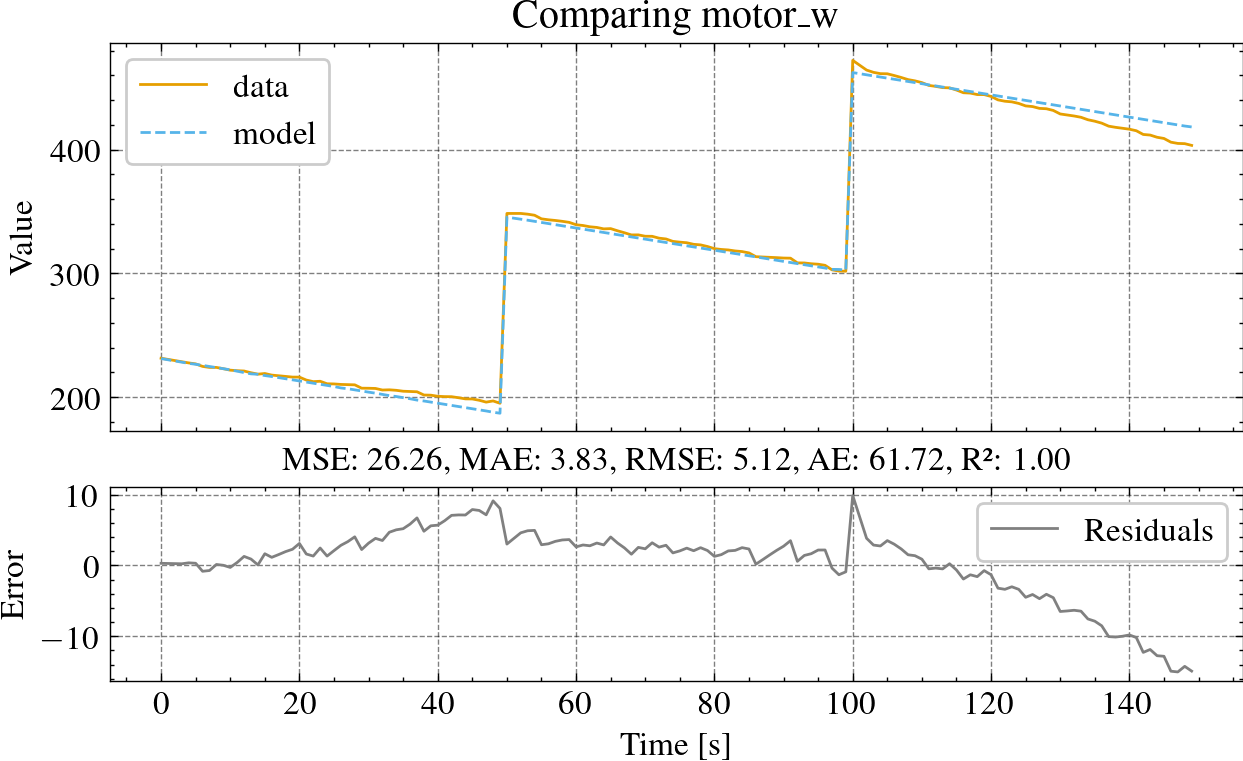

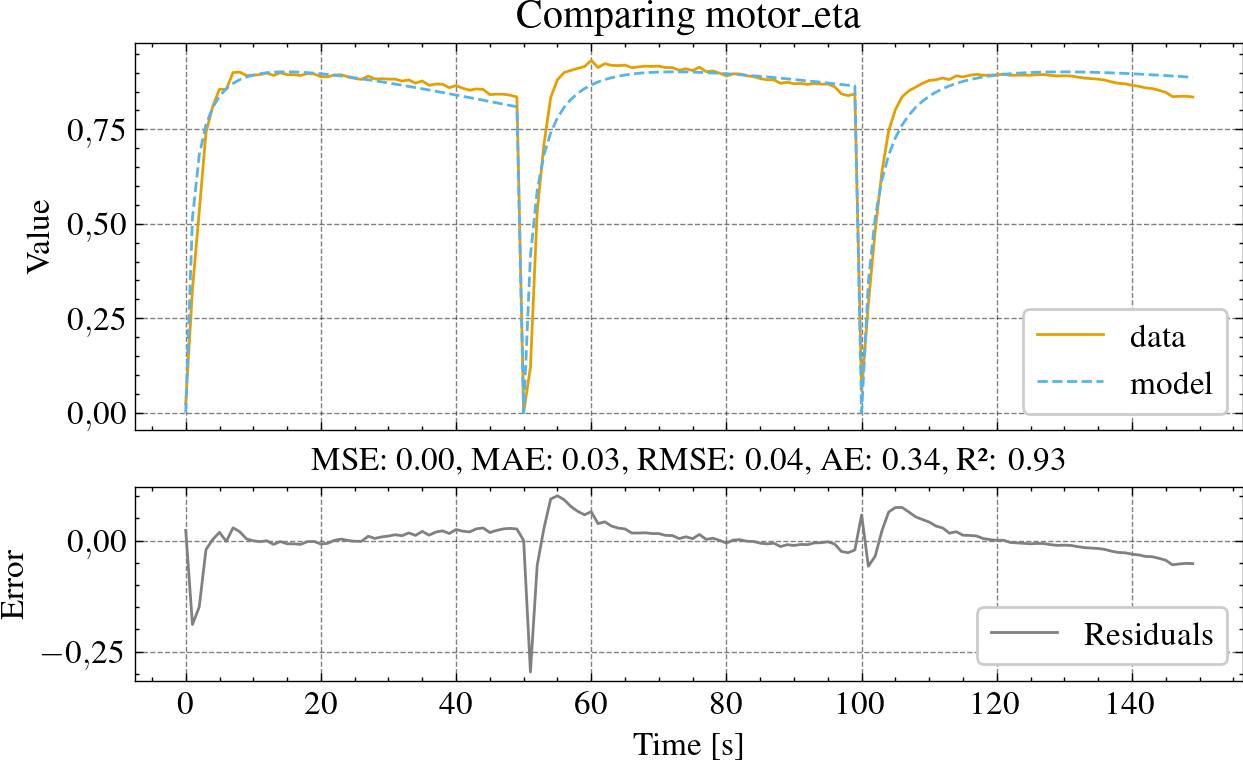

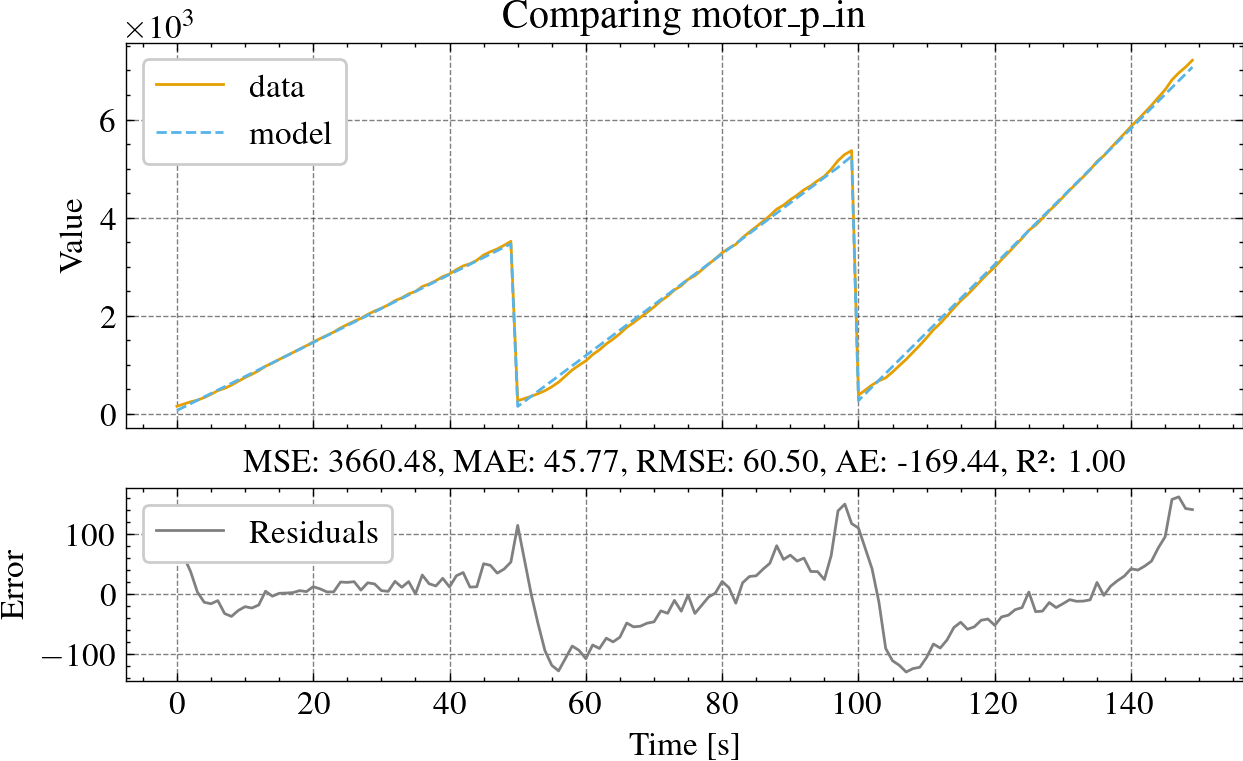

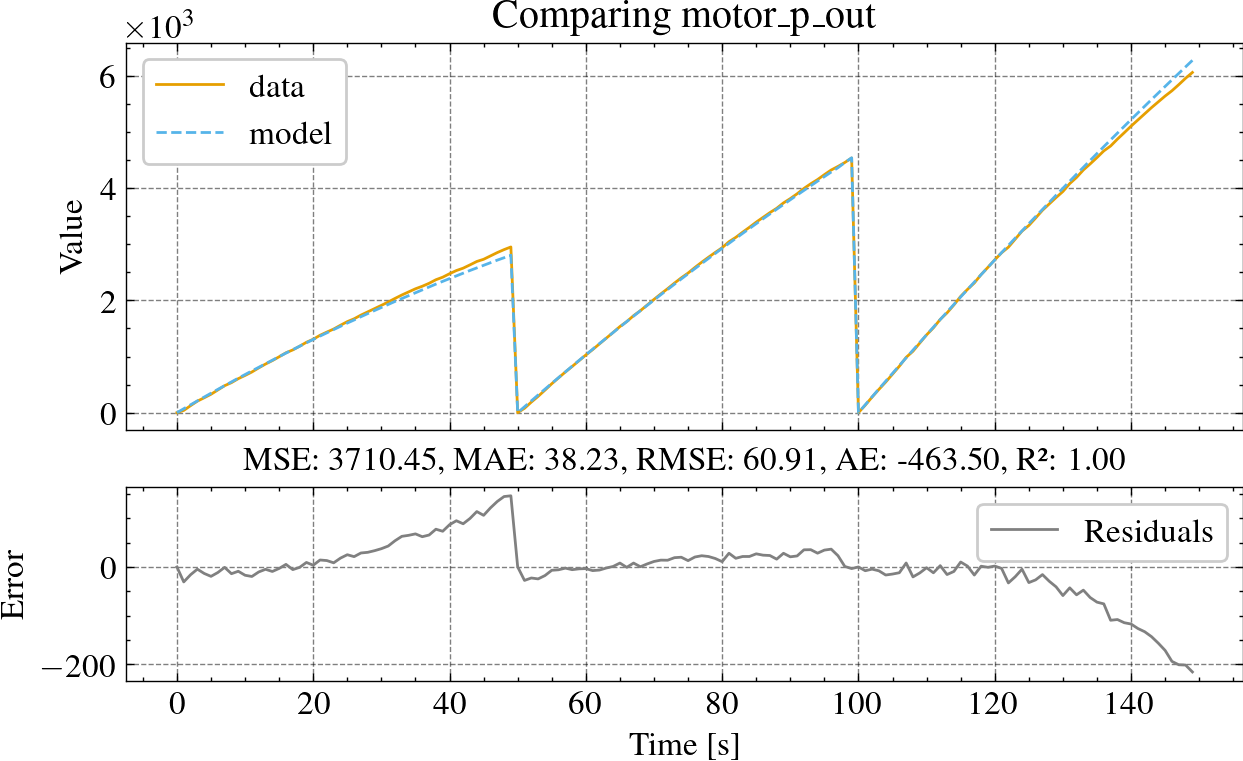

CPU times: user 10.1 s, sys: 3.3 s, total: 13.4 s
Wall time: 14 s


In [14]:
%%time
## MOTOR OPTIMIZATION

# Since we don't have a good initial guess, we force not to have a fallback, thus requiring to fit all three parameters
motor_params = {
    'motor_R_A': np.nan,
    'motor_B': np.nan,
    'motor_K_Q': np.nan,
    'motor_K_V': np.nan,
}

# Select the optimization data
data_cols = ['motor_i', 'motor_w', 'motor_eta', 'motor_p_in', 'motor_p_out']
input_cols = ['motor_v', 'motor_q_load']

# Put simulation data into df
df_train = df.copy(deep=True)[['t'] + data_cols + input_cols]

# Set model states initial conditions
input_initial_state = {}

# Initialize Parameters
params_bounds = {
    'motor_R_A': dict(min=1e-6, max=1),
    'motor_B': dict(min=1e-6, max=1),
    'motor_K_Q': dict(min=1e-6, max=1),
    'motor_K_V': dict(min=1e-6, max=1),
}

# Initialize the thread pool and create the runner
n_processes = 32
pool = Pool(processes=n_processes)
runner = StarmapParallelization(pool.starmap)
try:
    # Initialize the problem
    model = Motor
    model_params = motor_params
    problem = MyOptimizationProblem(
        model=model,
        model_function=model_function,
        training_data=df_train,
        training_data_columns=data_cols,
        model_params=model_params,
        opt_params_bounds=params_bounds,
        input_initial_state=input_initial_state,
        input_columns=input_cols,
        # data_scaler=RobustScaler,
        data_scaler=MinMaxScaler,
        elementwise_runner=runner,
    )

    algorithm = DE(
        pop_size=100*len(params_bounds),
        sampling=LHS(),
        variant="DE/rand/1/bin",
        F=0.5,
        CR=0.9,
    )

    # Specify termination criteria (optional)
    termination = DefaultSingleObjectiveTermination(
        xtol=1e-8,
        cvtol=1e-6,
        ftol=1e-6,
        period=100,
        n_max_gen=1000,
        n_max_evals=100000
    )

    # Run the optimization
    result = minimize(
        problem,
        algorithm,
        termination=termination,
        seed=42,
        verbose=True,
        save_history=True,
    )
    print('Threads:', result.exec_time)
finally:
    pool.close()
    pool.join()

# Print the results
best_params = convert_to_model_params({k: result.X[i] for (i, k) in enumerate(params_bounds.keys())})
original_params = {k: convert_to_model_params(motor_params)[k] for k in best_params.keys()}
print("Original parameters were:")
display(original_params)
print("Best parameters found:")
display(best_params)
print("Objective value at solution:", result.F)

plot_optimization_params(result, params_bounds)
plot_optimization_error(result, params_bounds)

T = np.ascontiguousarray(df_train['t'].to_numpy())
U = np.ascontiguousarray(df_train[['motor_v', 'motor_q_load']].to_numpy().T)
X0 = model.initial_state(X0=input_initial_state, U0=U[:,0], params=model_params | best_params)

best_fit_data = model_function(T, U, X0, **(motor_params | best_params))

for col in data_cols:
    plot_compare(df, best_fit_data, col)


In [15]:
params_output_path = 'me0909_steady_state_params.json'
save_model_params_to_json(params_output_path, model_params | best_params)
loaded_params = load_model_params_from_json(params_output_path)
loaded_params
        

{'motor_B': 0.0012793008044770459,
 'motor_K_Q': 0.10543193741528227,
 'motor_K_V': 0.10337093946599393,
 'motor_R_A': 0.03211280350781205}

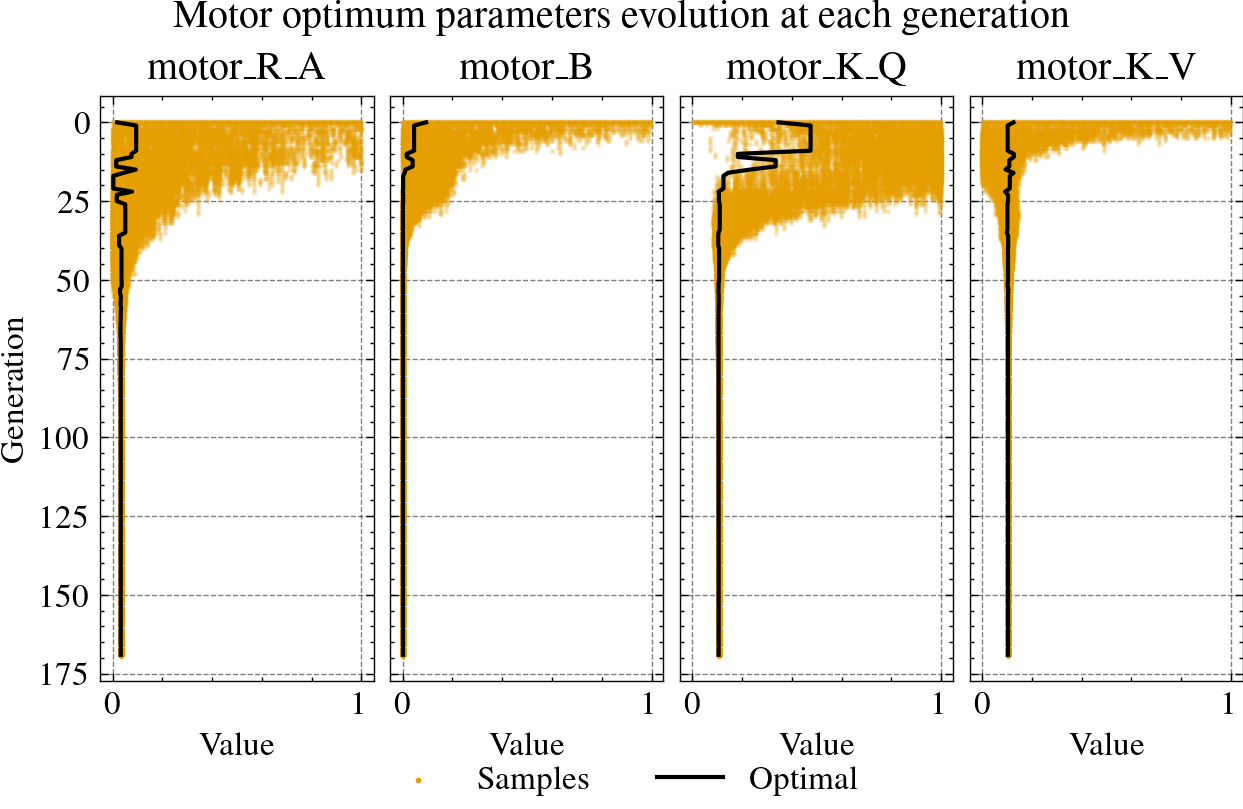

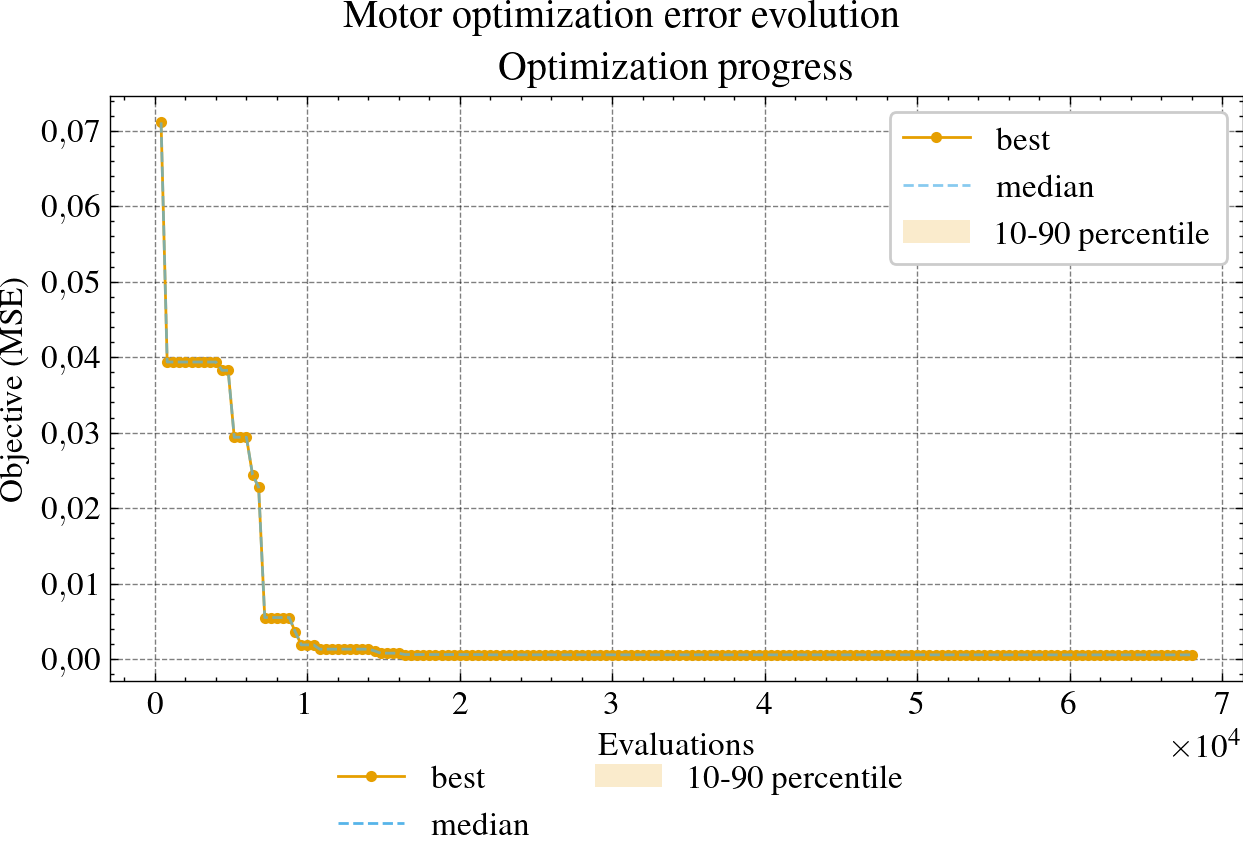

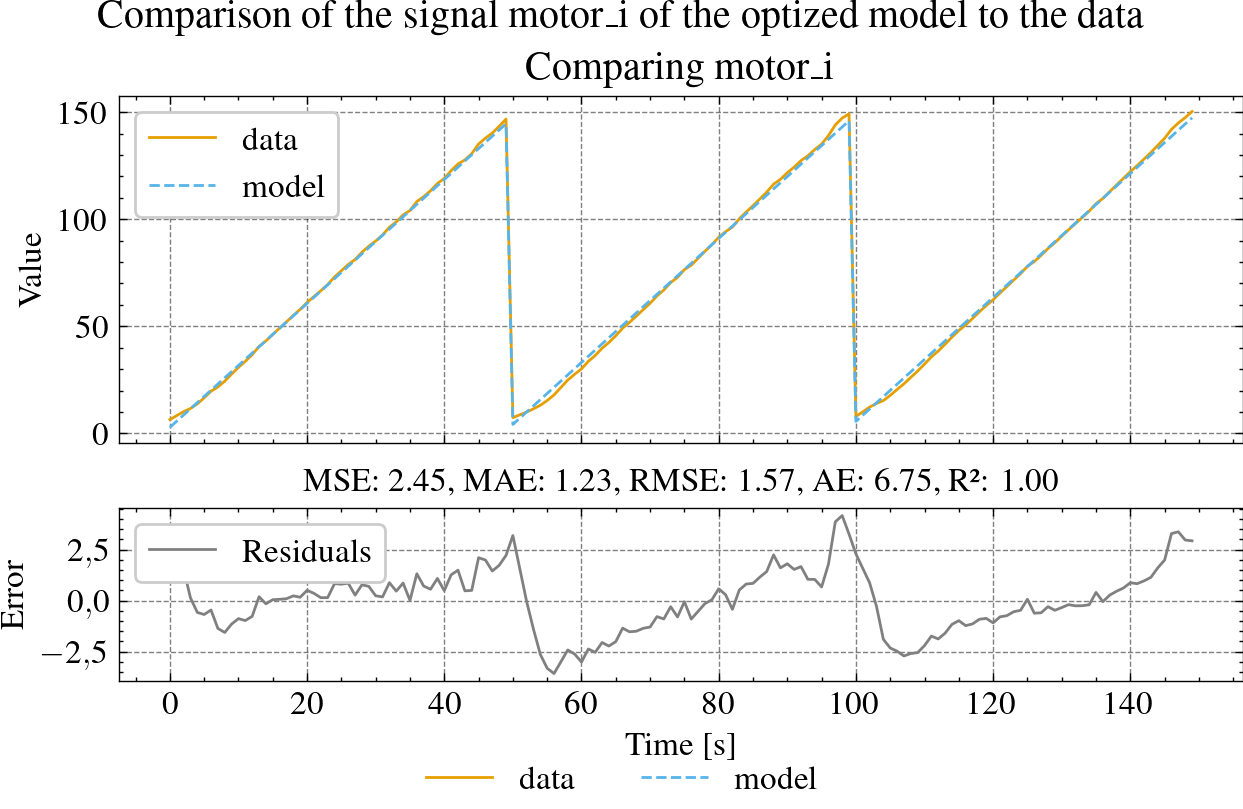

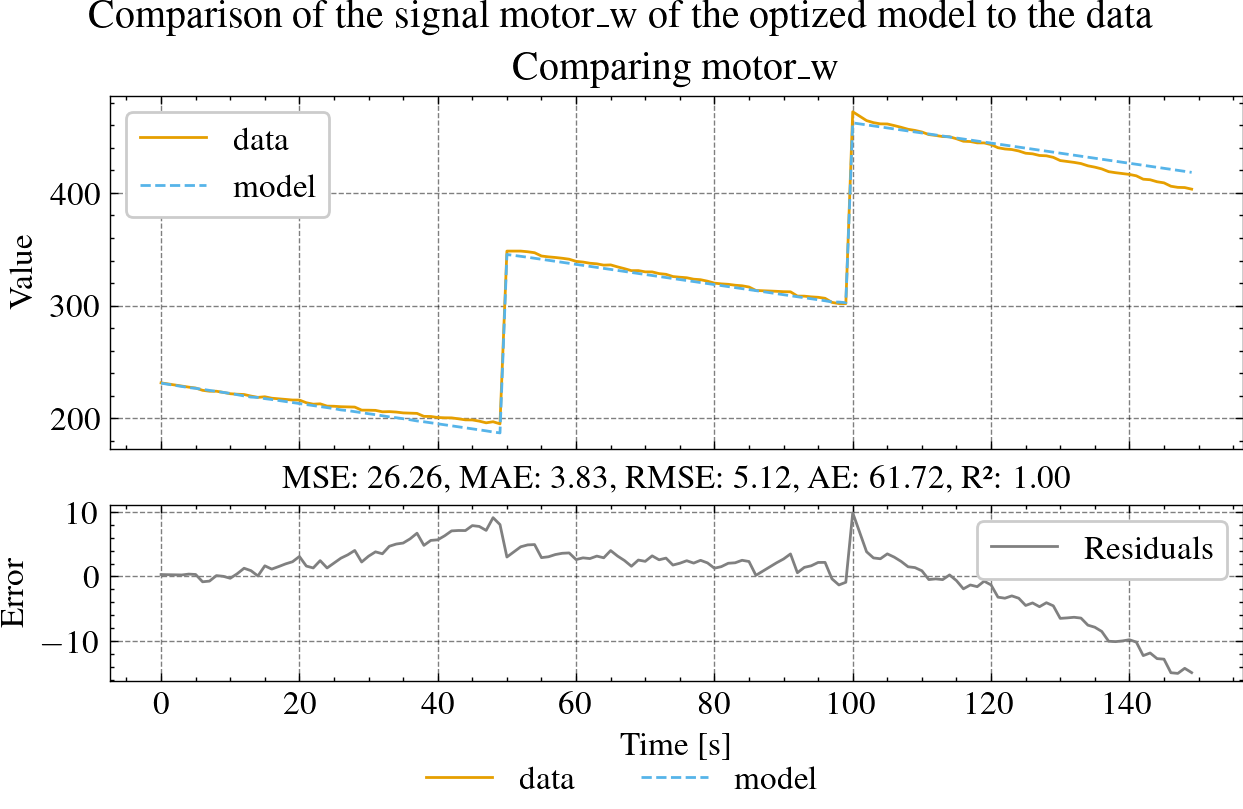

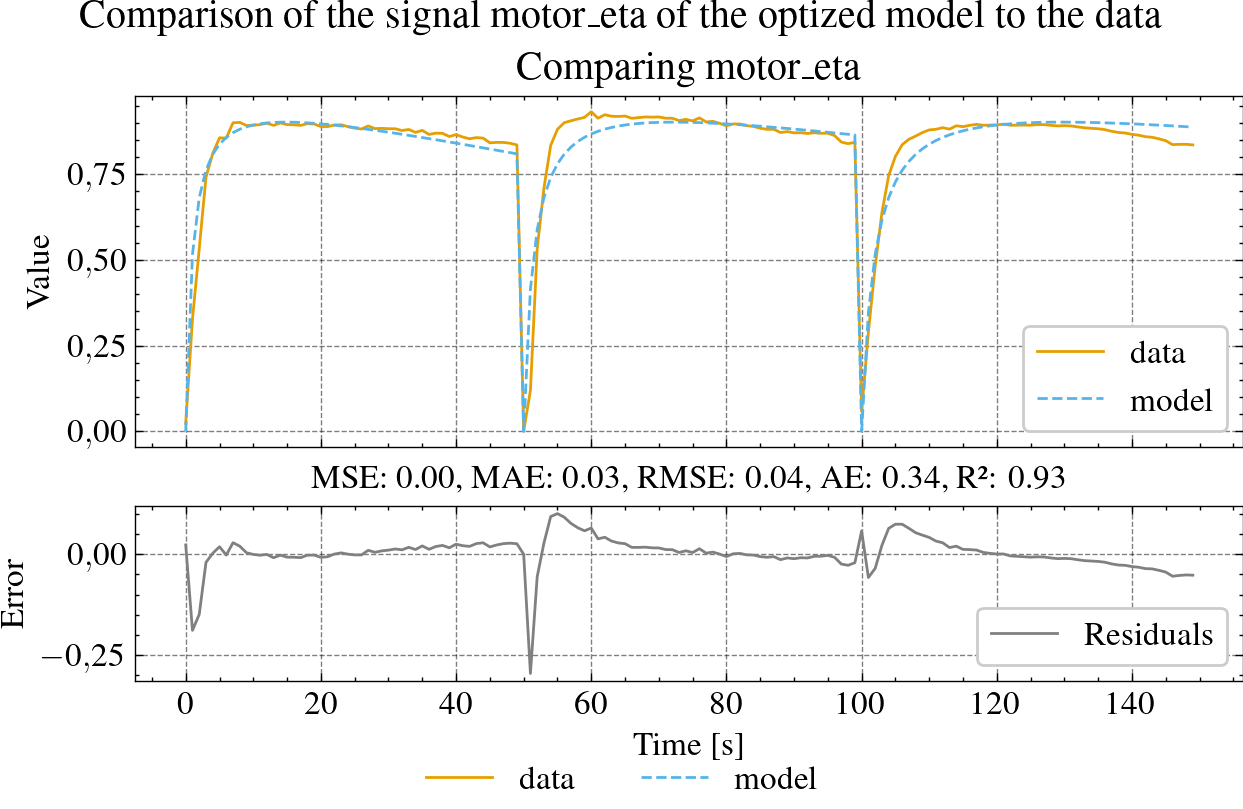

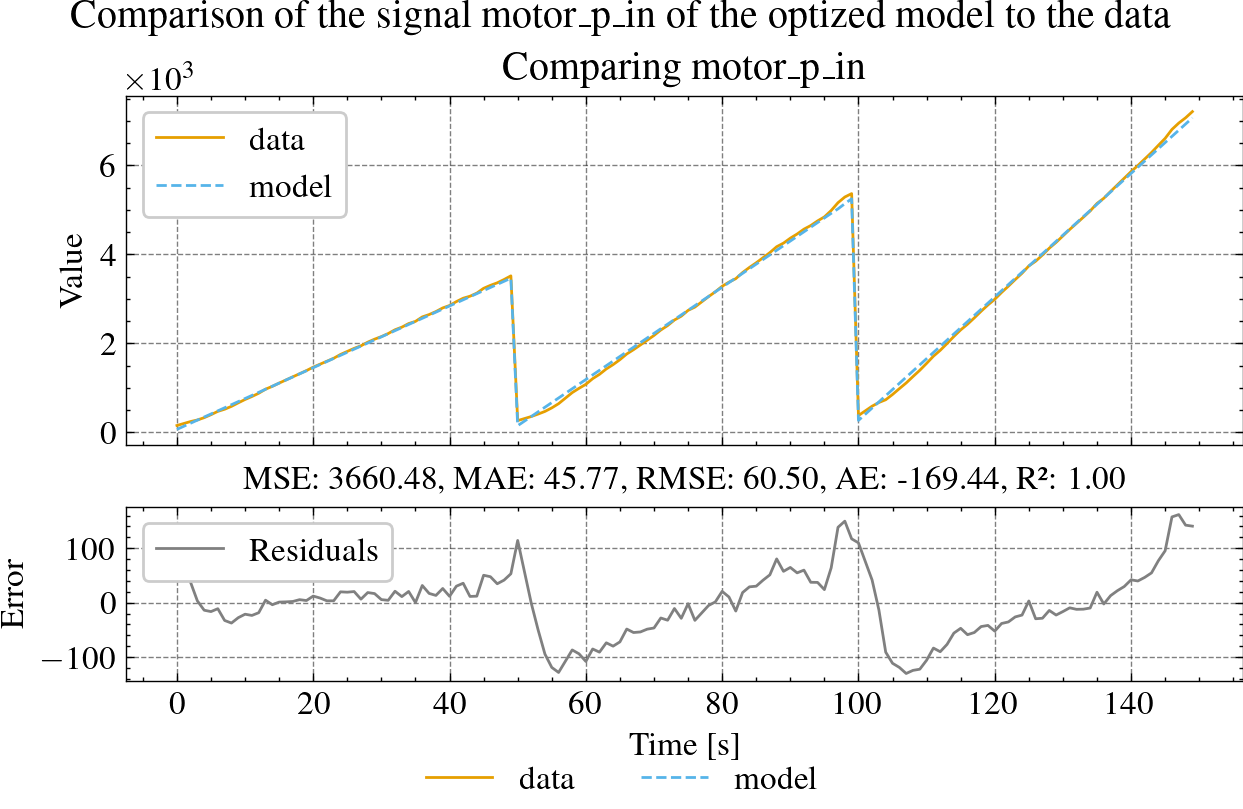

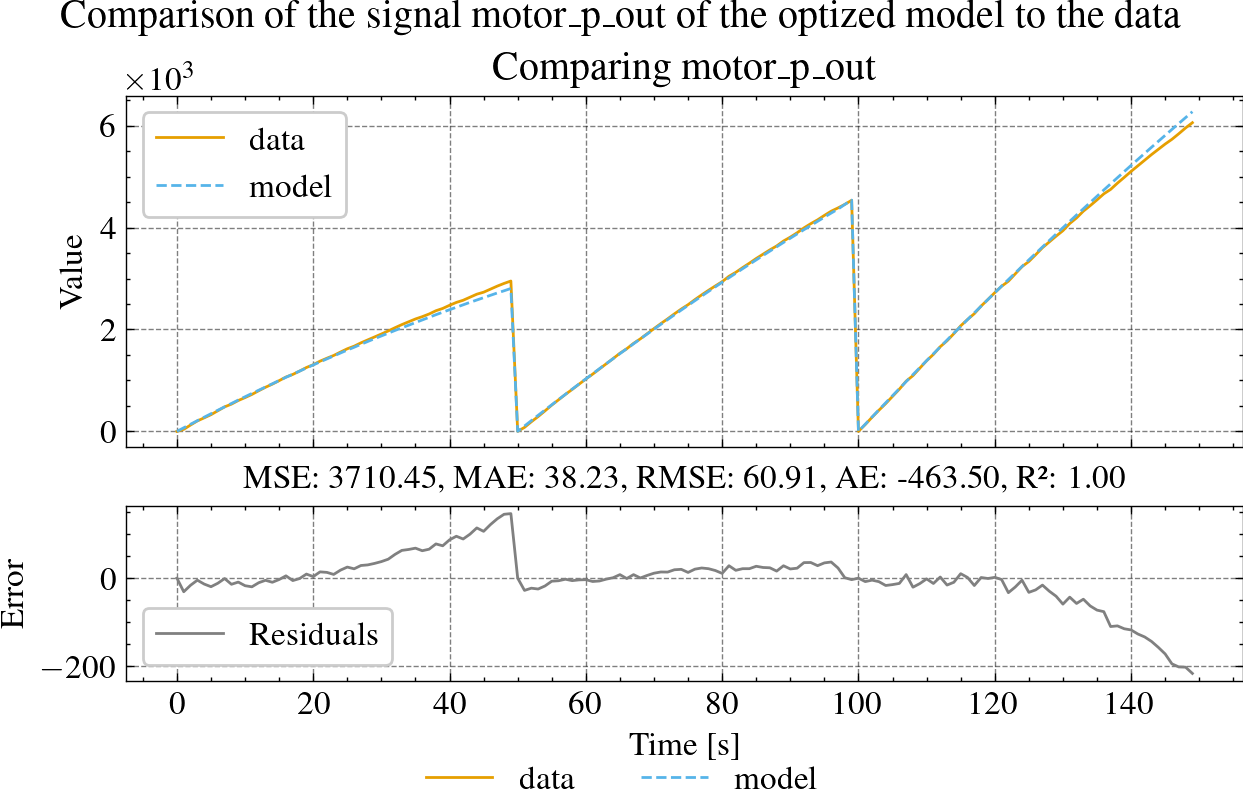

In [16]:
# Plot the original data and the fitted curve
fig_save_and_show(
    filename=f'{latex_img_path}/motor_steady_state_manufacturer_data_optimization_params.pdf',
    show_title='Motor optimum parameters evolution at each generation',
    save_title='Evolução dos parâmetros ótimos do motor à cada geração',
    ncol=2,
    fig=plot_optimization_params(result, params_bounds=params_bounds, scatter_alpha=0.2, scatter_size=1, show=False)
)

fig_save_and_show(
    filename=f'{latex_img_path}/motor_steady_state_manufacturer_data_optimization_error.pdf',
    show_title='Motor optimization error evolution',
    save_title='Evolução do erro de otimização do motor',
    ncol=2,
    fig=plot_optimization_error(result, show=False),
)

for col in data_cols:
    fig_save_and_show(
        filename=f'{latex_img_path}/motor_steady_state_manufacturer_data_optimization_residuals_{col}.pdf',
        show_title=f'Comparison of the signal {col} of the optized model to the data',
        save_title=f'Comparação do sinal {col} do modelo otimizado com o dado',
        ncol=2,
        fig=plot_compare(df_train, best_fit_data, col, show=False),
    )

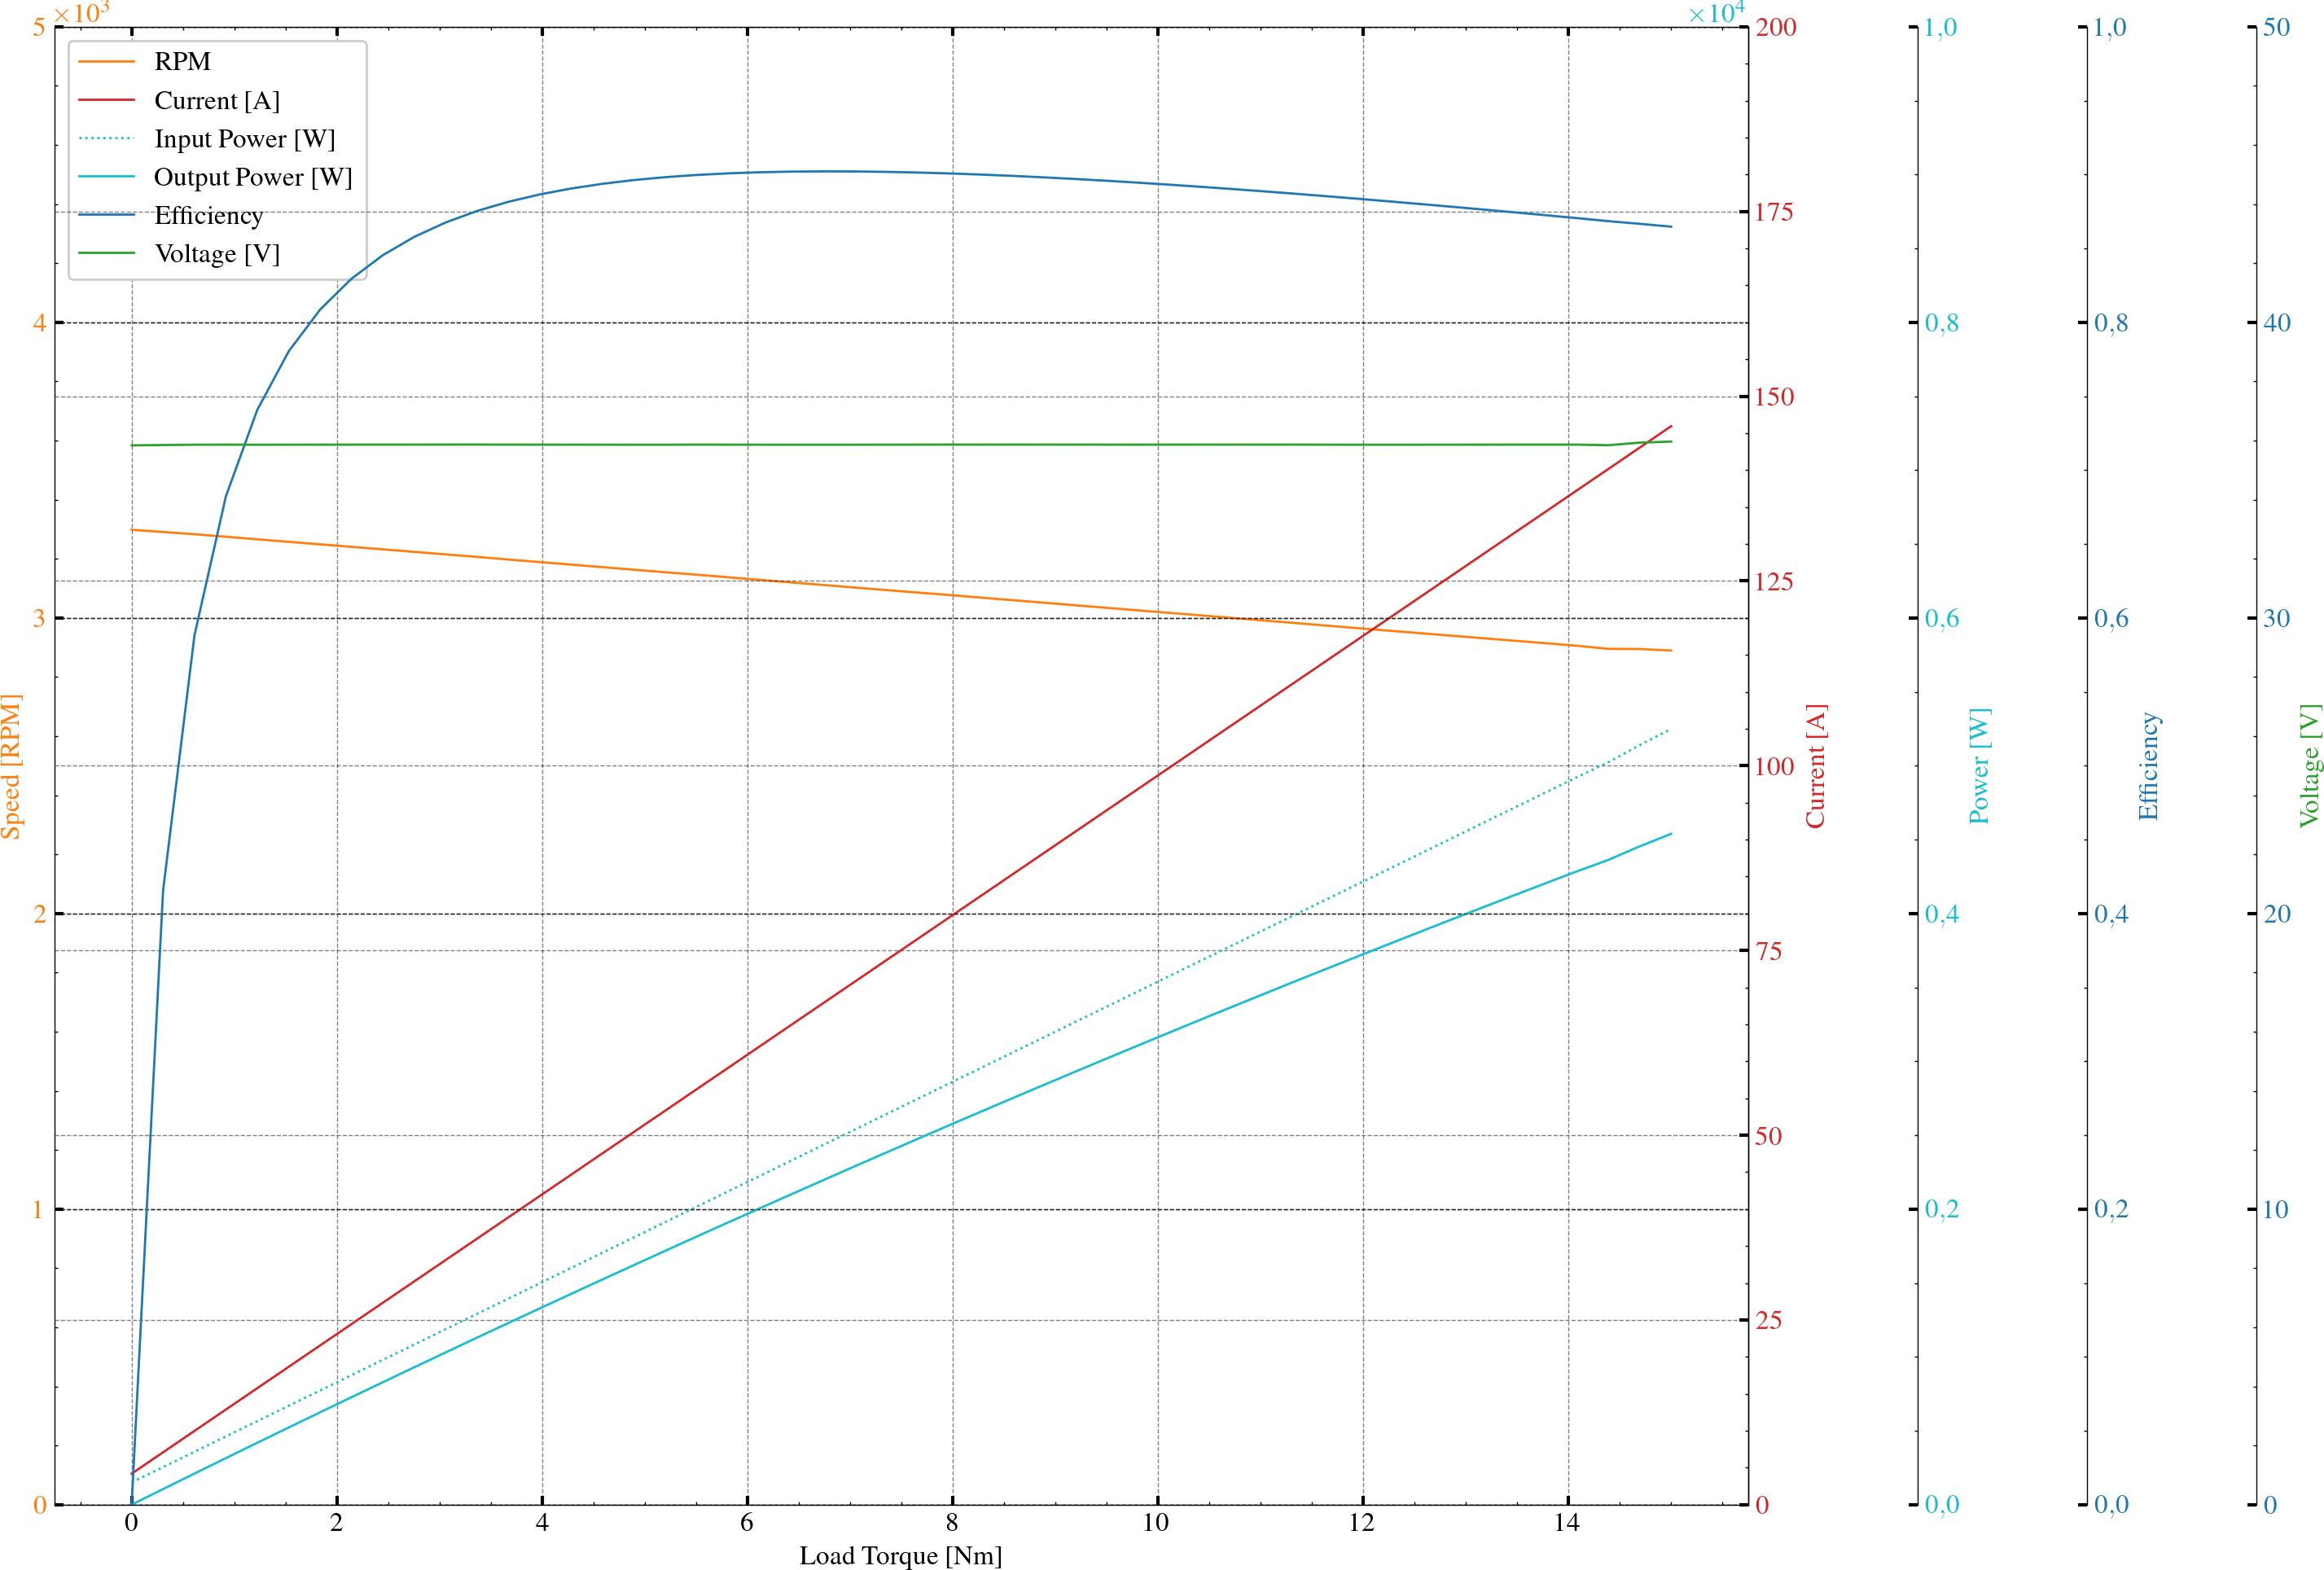

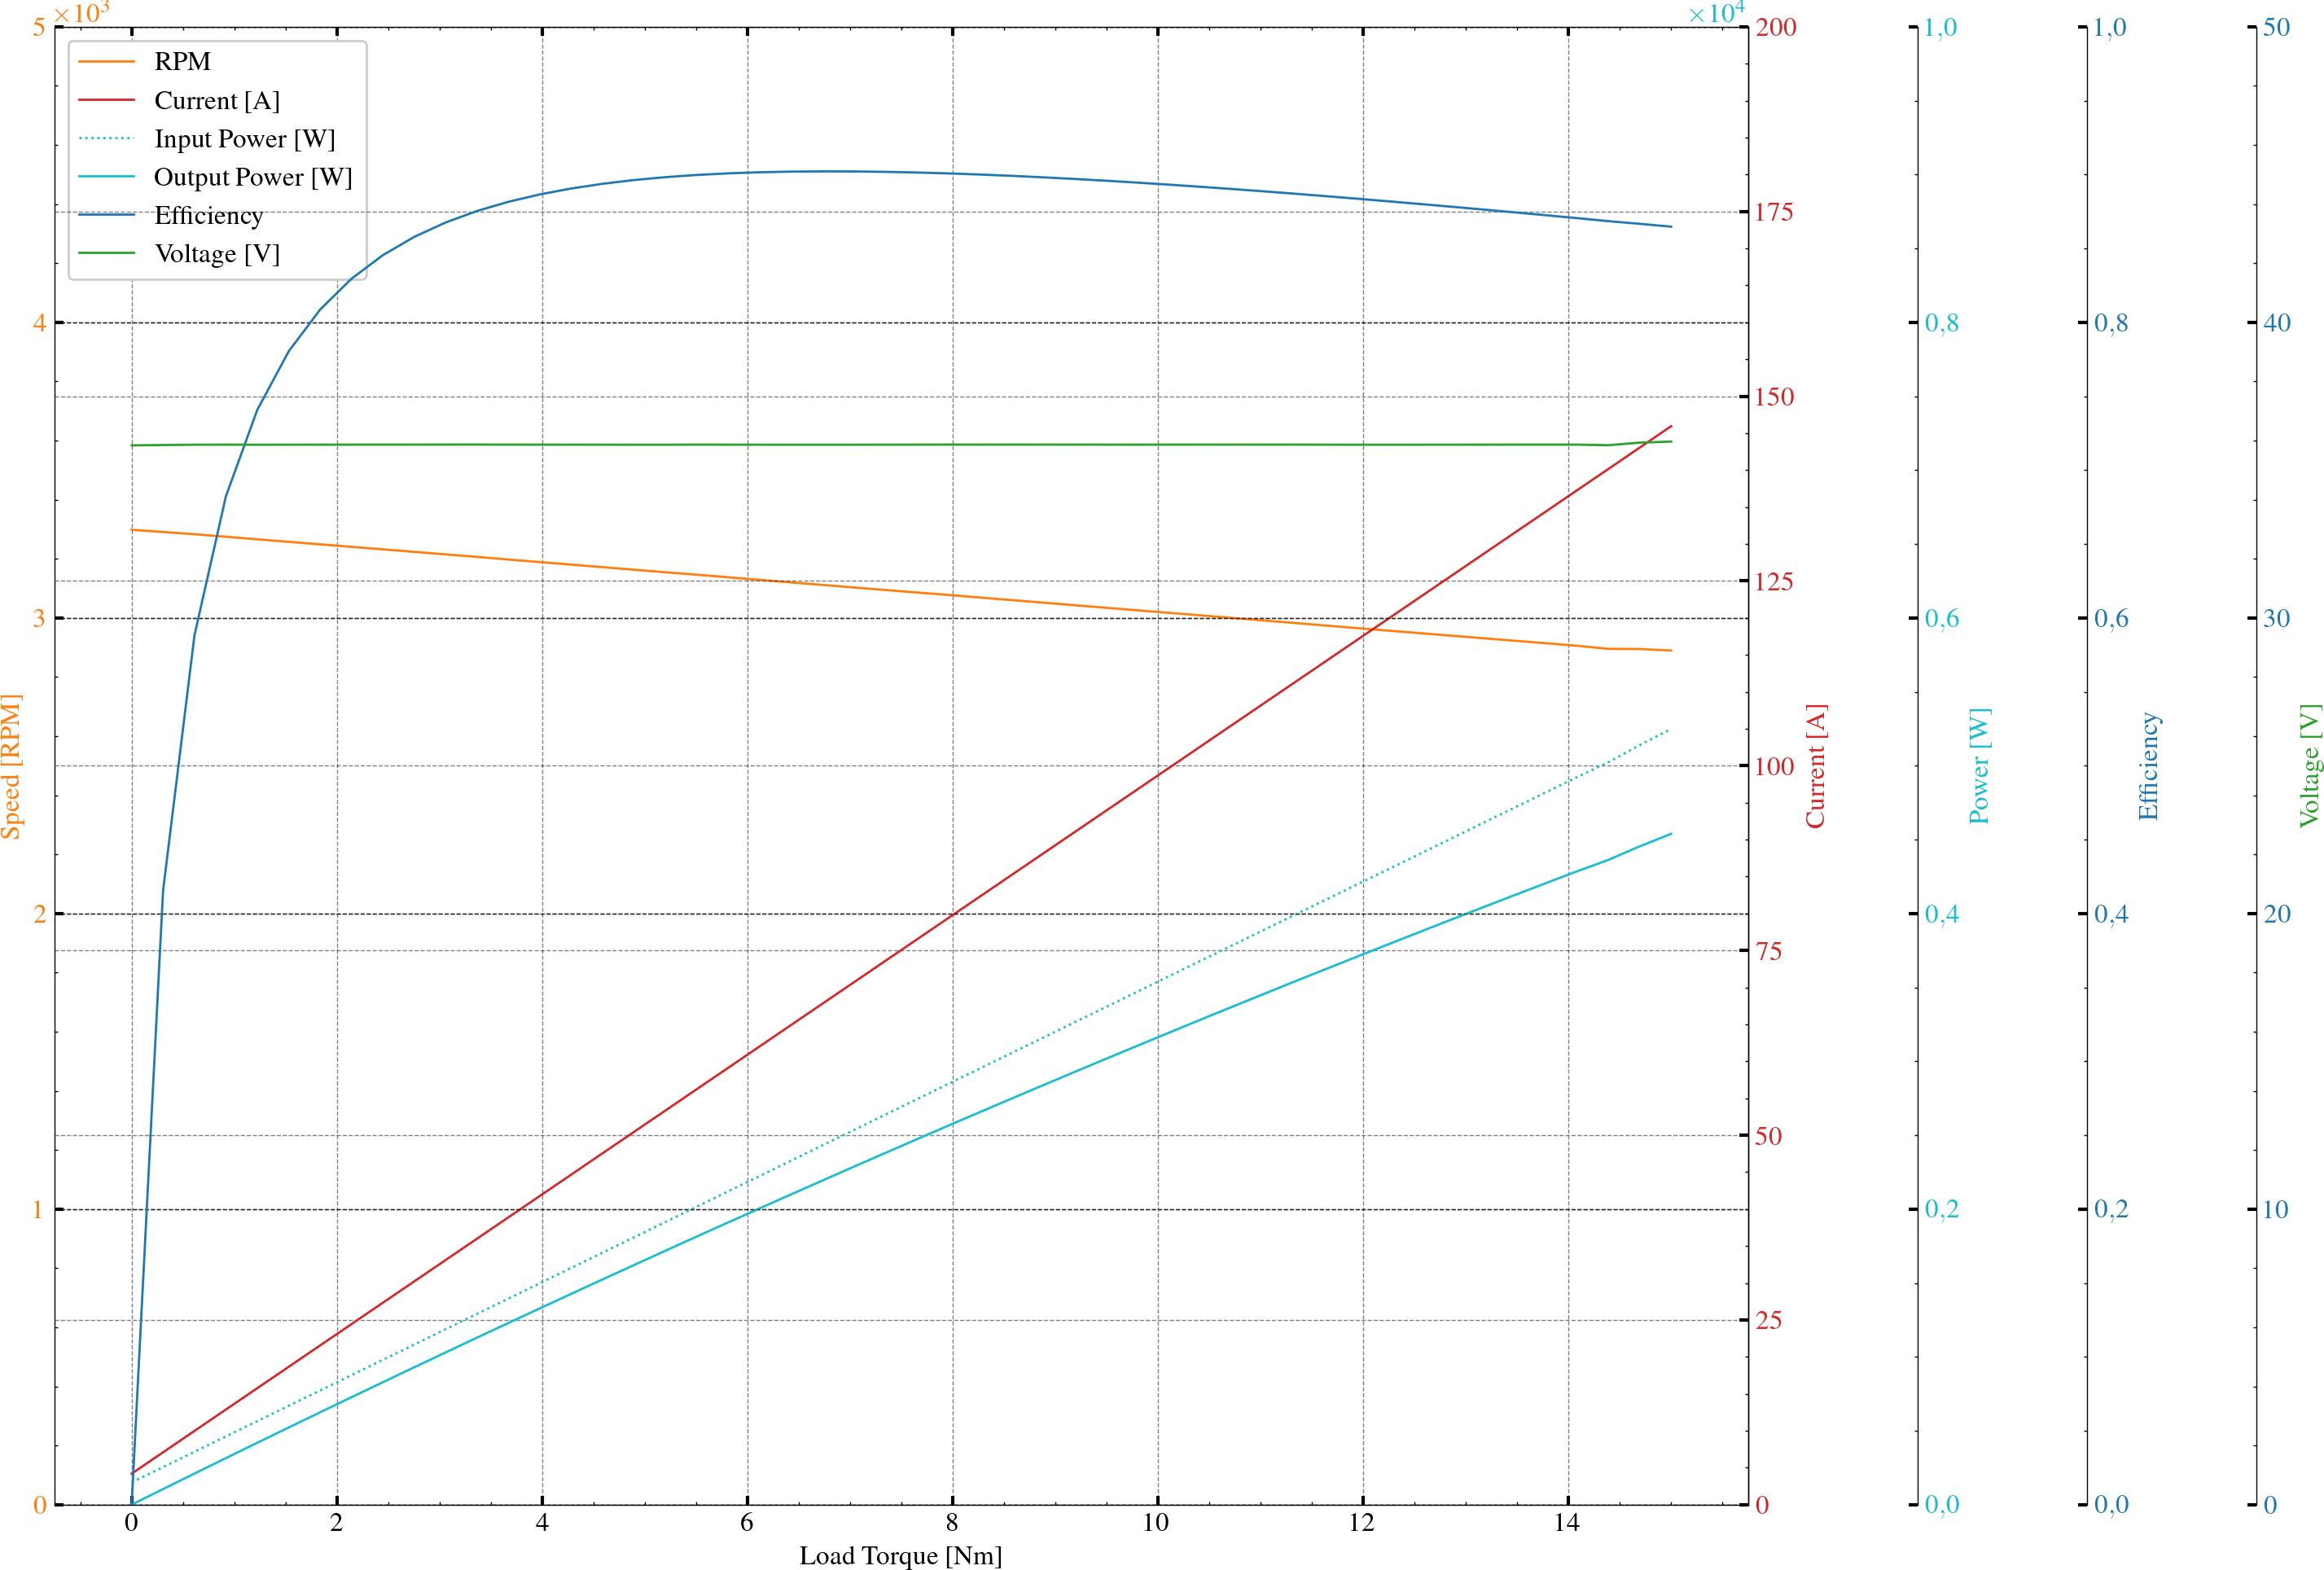

In [17]:
best_fit_data['motor_p_in'] = best_fit_data['motor_v'] * best_fit_data['motor_i']
best_fit_data['motor_p_out'] = best_fit_data['motor_q_load'] * best_fit_data['motor_w']
best_fit_data['motor_eta'] =  best_fit_data['motor_p_out'] / best_fit_data['motor_p_in']
plot_performance_graph(best_fit_data.iloc[50:100])

In [18]:
model_params | best_params

{'motor_R_A': 0.03211280350781205,
 'motor_B': 0.0012793008044770459,
 'motor_K_Q': 0.10543193741528227,
 'motor_K_V': 0.10337093946599393}